Using the ivar weighted data with the galaxy mask implemented in angle_calc_1729369367 (from 10/19/24), I am going to examine more closely why some of the maps don't give good likelihoods or yield angles far from zero. The goal is to find good quantitive ways of cutting bad S/N maps and/or identifying ways to improve the analysis.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pixell import enmap, enplot, reproject, utils, curvedsky
from tqdm import tqdm
import pandas as pd
import nawrapper as nw
import yaml
import time
import healpy as hp

In [2]:
# Loading spectra from run
spectra_dict = np.load('/home/zbh5/act_analysis/act_axion_analysis/results/angle_calc_1729369367/angle_calc_1729369367_spectra.npy',allow_pickle=True).item()

In [3]:
maps = np.array(list(spectra_dict.keys()))
n_maps = len(maps)
print(n_maps)
print(spectra_dict[maps[0]].keys())

73
dict_keys(['ell', 'E1xB2', 'E2xB1', 'E1xE1', 'B2xB2', 'E2xE2', 'B1xB1', 'E1xE2', 'B1xB2', 'E1xB1', 'E2xB2', 'binned_nu', 'estimator', 'covariance', 'CAMB_EE', 'CAMB_BB', 'w2_depth1', 'w2_cross', 'w2_ref', 'meas_angle', 'meas_errbar', 'ivar_sum', 'map_cut'])


In [4]:
for i in range(n_maps):
    if spectra_dict[maps[i]]['map_cut'] == 1:
        print(i)

43
44
45
49
50
51


In [5]:
maps[55]

'depth1_1617308981_pa4_f150_map.fits'

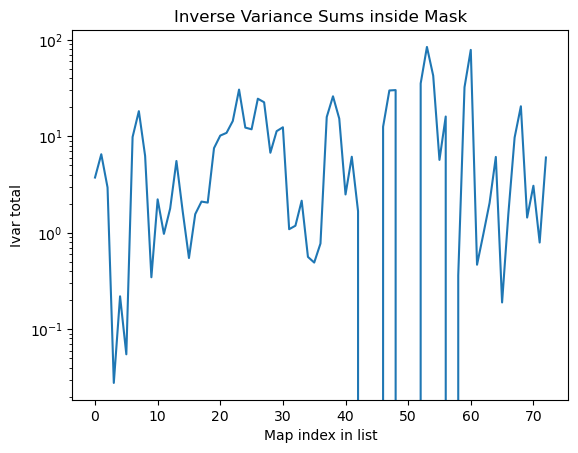

In [6]:
# Investigating trends in ivar_sum

ivar_sums = np.zeros(n_maps)
for i in range(n_maps):
    ivar_sums[i] = spectra_dict[maps[i]]['ivar_sum']
plt.semilogy(ivar_sums)
plt.title("Inverse Variance Sums inside Mask")
plt.ylabel("Ivar total")
plt.xlabel("Map index in list")
plt.show()
plt.close()

112
5.700000000000001
0.14285714285714285
0.7


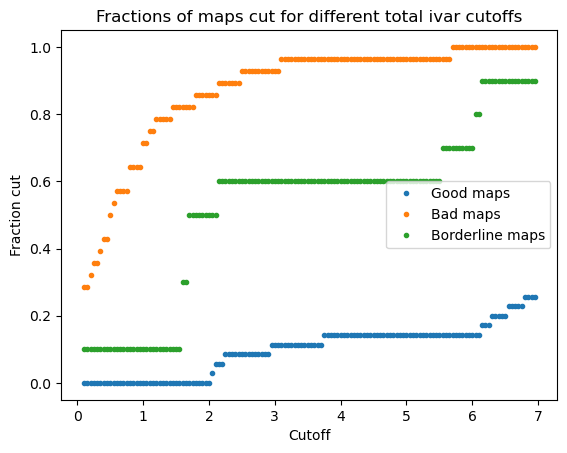

In [7]:
# Iterating over different cutoffs to examine fraction that is cut
# List of indices from looking at likelihoods by eye
very_good = [1,20,21,22,23,24,25,26,27,28,29,30,37,38,39,47,48,52,53,54,56,59,60,67,68]
good = [0,2,6,7,8,10,18,19,63,64]
borderline = [5,13,14,16,17,41,42,46,66,72]
bad = [3,4,9,11,12,15,31,32,33,34,35,36,40,55,57,58,61,62,65,69,70,71]
cut = [43,44,45,49,50,51]
all_good = np.sort(very_good+good)
all_bad = np.sort(bad+cut)

good_fractions_cut = []
bad_fractions_cut = []
border_fractions_cut = []
cutoffs = np.arange(0.1,7.0,0.05)
for cutoff in cutoffs:
    in_good = 0
    in_bad = 0
    in_border = 0
    outlier_indices_ivar_sums = np.where(ivar_sums < cutoff)[0]
    num_outlier = len(outlier_indices_ivar_sums)
    for i in range(num_outlier):
        if outlier_indices_ivar_sums[i] in all_good: in_good += 1
        elif outlier_indices_ivar_sums[i] in all_bad: in_bad += 1
        elif outlier_indices_ivar_sums[i] in borderline: in_border += 1
        else: print("index " + str(i) + " not in any list")
    good_fractions_cut.append(in_good/len(all_good))
    bad_fractions_cut.append(in_bad/len(all_bad))
    border_fractions_cut.append(in_border/len(borderline))

bad_fractions_cut = np.array(bad_fractions_cut)
# Finding the index at which all the bad maps are cut
index_all_bad_cut = np.where(bad_fractions_cut == 1.0)[0][0]
print(index_all_bad_cut)
print(cutoffs[index_all_bad_cut])
print(good_fractions_cut[index_all_bad_cut])
print(border_fractions_cut[index_all_bad_cut])
    
plt.plot(cutoffs, good_fractions_cut, '.', label="Good maps")
plt.plot(cutoffs, bad_fractions_cut, '.', label="Bad maps")
plt.plot(cutoffs, border_fractions_cut, '.', label="Borderline maps")
plt.legend()
plt.title("Fractions of maps cut for different total ivar cutoffs")
plt.xlabel("Cutoff")
plt.ylabel("Fraction cut")
plt.show()
plt.close()

In [8]:
print(ivar_sums[good])

[ 3.73638378  2.94912079  9.83269713 18.23927232  6.26028584  2.21885135
  2.05389603  7.53875619  2.03618897  6.11252124]


In [9]:
ivar_sums[55]

5.695267785193419

In [10]:
map_arrays = []
for i in range(n_maps):
    map_arrays.append(maps[i].split('_')[2])
map_arrays = np.array(map_arrays)

In [11]:
# Checking for each array how many maps fall into each category
pa4_indices = np.where(map_arrays=='pa4')[0]
pa5_indices = np.where(map_arrays=='pa5')[0]
pa6_indices = np.where(map_arrays=='pa6')[0]

pa4_good = 0; pa4_bad = 0; pa4_border = 0
pa5_good = 0; pa5_bad = 0; pa5_border = 0
pa6_good = 0; pa6_bad = 0; pa6_border = 0

for i in range(n_maps):
    if i in pa4_indices: 
        if i in all_good: pa4_good += 1
        elif i in all_bad: pa4_bad += 1
        elif i in borderline: pa4_border += 1
        else: print("index " + str(i) + " not in any list")
    elif i in pa5_indices: 
        if i in all_good: pa5_good += 1
        elif i in all_bad: pa5_bad += 1
        elif i in borderline: pa5_border += 1
        else: print("index " + str(i) + " not in any list")
    elif i in pa6_indices: 
        if i in all_good: pa6_good += 1
        elif i in all_bad: pa6_bad += 1
        elif i in borderline: pa6_border += 1
        else: print("index " + str(i) + " not in any list")
    else: 
        print("index " + str(i) + " not in any list")

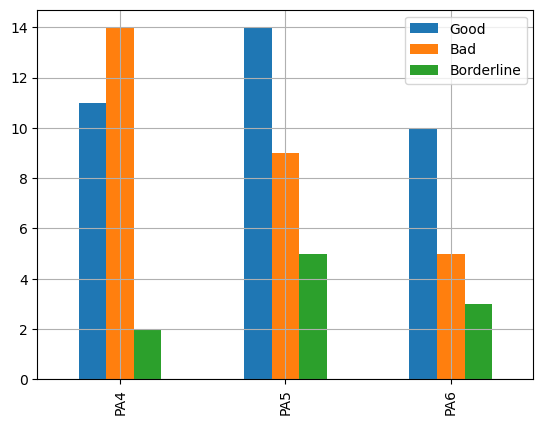

In [12]:
_data = {'Good': [pa4_good,pa5_good,pa6_good], 'Bad': [pa4_bad,pa5_bad,pa6_bad], 'Borderline': [pa4_border,pa5_border,pa6_border]}
_df = pd.DataFrame(_data,columns=['Good', 'Bad', 'Borderline'], index = ['PA4', 'PA5', 'PA6'])
ax = _df.plot.bar()
plt.grid()

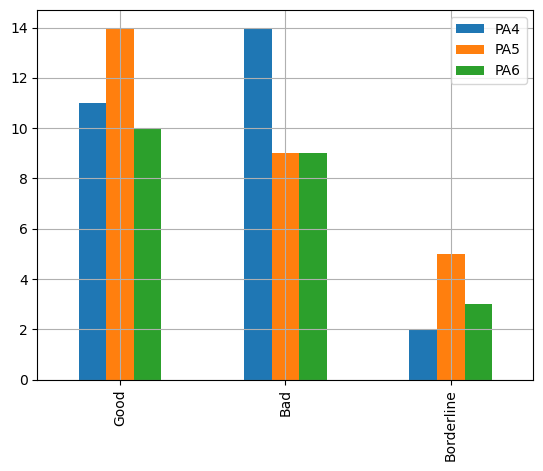

In [13]:
_data = {'PA4': [pa4_good,pa4_bad,pa4_border], 'PA5': [pa5_good,pa5_bad,pa5_border], 'PA6': [pa6_good,pa5_bad,pa6_border]}
_df = pd.DataFrame(_data,index=['Good', 'Bad', 'Borderline'], columns = ['PA4', 'PA5', 'PA6'])
ax = _df.plot.bar()
plt.grid()

In [14]:
angles = np.zeros(n_maps)
errbars = np.zeros(n_maps)
for i in range(n_maps):
    angles[i] = spectra_dict[maps[i]]['meas_angle']
    errbars[i] = spectra_dict[maps[i]]['meas_errbar']

In [15]:
# Implemnting tests for the difference between angles for the same timestamp but different arrays
pa4_pa5 = []
pa5_pa6 = []
pa4_pa6 = []

good_maps = np.array(maps[all_good])
good_timestamps = np.array([m.split('_')[1] for m in good_maps])
#print(good_maps)
#print(good_timestamps)
ts = np.unique(good_timestamps)
#print(ts)
for t in ts:
    indices = all_good[np.where(good_timestamps==t)[0]] # Getting indices in the full list of 73 for this timestamp
    array_names = map_arrays[indices]
    array_names_rolled = np.roll(array_names,-1)
    map_names = maps[indices]
    temp_angles = angles[indices]
    temp_errbars = errbars[indices]
    #print(indices)
    #print(array_names)
    print(map_names)
    print(temp_angles)
    print(temp_errbars)
    if len(indices)>1:
        diff = (temp_angles/temp_errbars) - np.roll(temp_angles/temp_errbars, -1)
        for i in range(len(indices)):
            # Since arrays are sorted by name, pa6 should never appear first
            # This will currently not work for pa4-pa6 only (i.e. no pa5)
            if array_names[i]=='pa4':
                if array_names_rolled[i]=='pa5': pa4_pa5.append(diff[0])
                else: print("Issue with " + map_names[i])
            elif array_names[i]=='pa5':
                if array_names_rolled[i]=='pa6': pa5_pa6.append(diff[1])
                elif array_names_rolled[i]=='pa4': continue # already caught in pa4
                else: print("Issue with " + map_names[i])
            elif array_names[i]=='pa6':
                if array_names_rolled[i]=='pa4': pa4_pa6.append(diff[2])
                elif array_names_rolled[i]=='pa5': continue # already caught in pa5
                else: print("Issue with " + map_names[i])
            else: print("Issue with " + map_names[i])
print(pa4_pa5)
print(pa4_pa6)
print(pa5_pa6)

['depth1_1494463440_pa4_f150_map.fits'
 'depth1_1494463440_pa5_f150_map.fits'
 'depth1_1494463440_pa6_f150_map.fits']
[0.12204732 5.84215215 7.31979228]
[13.20051529  8.86743988 11.32530125]
['depth1_1494479992_pa4_f150_map.fits'
 'depth1_1494479992_pa5_f150_map.fits'
 'depth1_1494479992_pa6_f150_map.fits']
[-4.30041101 12.8184689   8.57051398]
[7.80149128 7.2940757  6.73934631]
['depth1_1494565020_pa5_f150_map.fits']
[8.85933843]
[10.27729445]
['depth1_1494726991_pa6_f150_map.fits']
[10.32821791]
[10.64873787]
['depth1_1494735603_pa4_f150_map.fits'
 'depth1_1494735603_pa5_f150_map.fits'
 'depth1_1494735603_pa6_f150_map.fits']
[-11.3471456   -1.48719375  -3.58230843]
[7.82509523 5.15298607 4.13554286]
['depth1_1494743515_pa4_f150_map.fits'
 'depth1_1494743515_pa5_f150_map.fits'
 'depth1_1494743515_pa6_f150_map.fits']
[-2.71275821  0.48979463 -2.56925997]
[5.55346376 4.90997355 3.34795574]
['depth1_1494761700_pa4_f150_map.fits'
 'depth1_1494761700_pa5_f150_map.fits'
 'depth1_1494761700_

In [16]:
print(len(pa4_pa5))
print(len(pa4_pa6))
print(len(pa5_pa6))

11
8
9


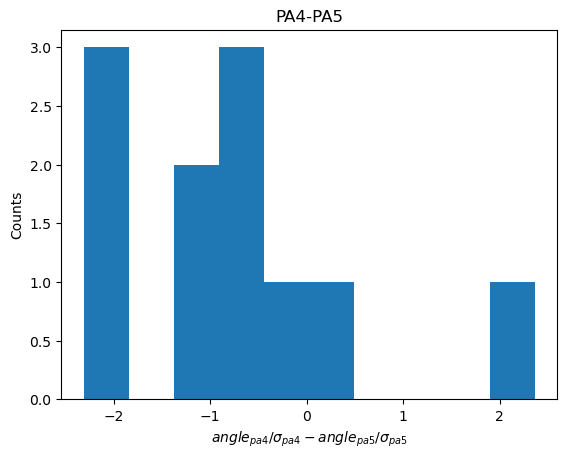

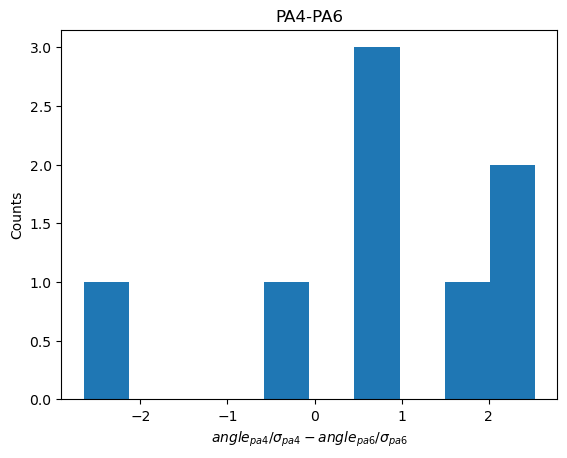

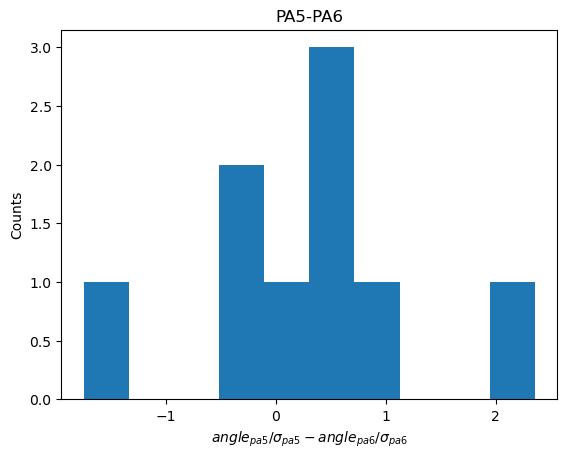

In [17]:
plt.hist(pa4_pa5)
plt.title("PA4-PA5")
plt.ylabel("Counts")
plt.xlabel("$angle_{pa4}/\sigma_{pa4} - angle_{pa5}/\sigma_{pa5}$")
plt.show()
plt.close()
plt.hist(pa4_pa6)
plt.title("PA4-PA6")
plt.ylabel("Counts")
plt.xlabel("$angle_{pa4}/\sigma_{pa4} - angle_{pa6}/\sigma_{pa6}$")
plt.show()
plt.close()
plt.hist(pa5_pa6)
plt.title("PA5-PA6")
plt.ylabel("Counts")
plt.xlabel("$angle_{pa5}/\sigma_{pa5} - angle_{pa6}/\sigma_{pa6}$")
plt.show()
plt.close()

In [25]:
# Doing same test but without dividing by sigma
pa4_pa5 = []
pa5_pa6 = []
pa4_pa6 = []

good_maps = np.array(maps[all_good])
good_timestamps = np.array([m.split('_')[1] for m in good_maps])
#print(good_maps)
#print(good_timestamps)
ts = np.unique(good_timestamps)
#print(ts)
for t in ts:
    indices = all_good[np.where(good_timestamps==t)[0]] # Getting indices in the full list of 73 for this timestamp
    array_names = map_arrays[indices]
    array_names_rolled = np.roll(array_names,-1)
    map_names = maps[indices]
    temp_angles = angles[indices]
    temp_errbars = errbars[indices]
    #print(indices)
    #print(array_names)
    #print(map_names)
    #print(temp_angles)
    #print(temp_errbars)
    if len(indices)>1:
        diff = (temp_angles) - np.roll(temp_angles, -1)
        for i in range(len(indices)):
            # Since arrays are sorted by name, pa6 should never appear first
            # This will currently not work for pa4-pa6 only (i.e. no pa5)
            if array_names[i]=='pa4':
                if array_names_rolled[i]=='pa5': pa4_pa5.append(diff[0])
                else: print("Issue with " + map_names[i])
            elif array_names[i]=='pa5':
                if array_names_rolled[i]=='pa6': pa5_pa6.append(diff[1])
                elif array_names_rolled[i]=='pa4': continue # already caught in pa4
                else: print("Issue with " + map_names[i])
            elif array_names[i]=='pa6':
                if array_names_rolled[i]=='pa4': pa4_pa6.append(diff[2])
                elif array_names_rolled[i]=='pa5': continue # already caught in pa5
                else: print("Issue with " + map_names[i])
            else: print("Issue with " + map_names[i])
#print(pa4_pa5)
#print(pa4_pa6)
#print(pa5_pa6)

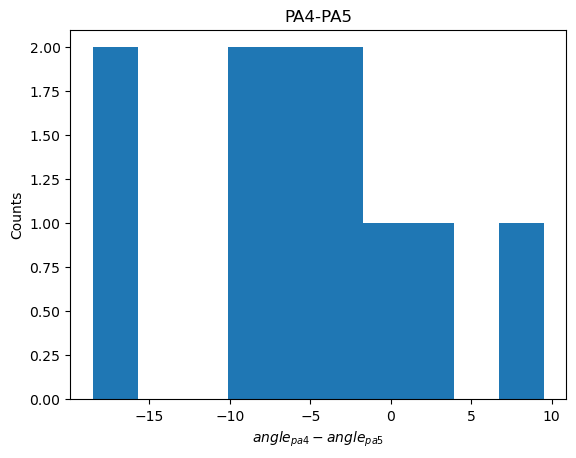

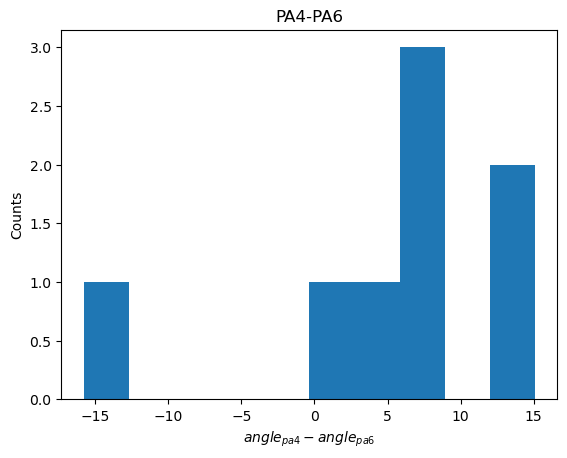

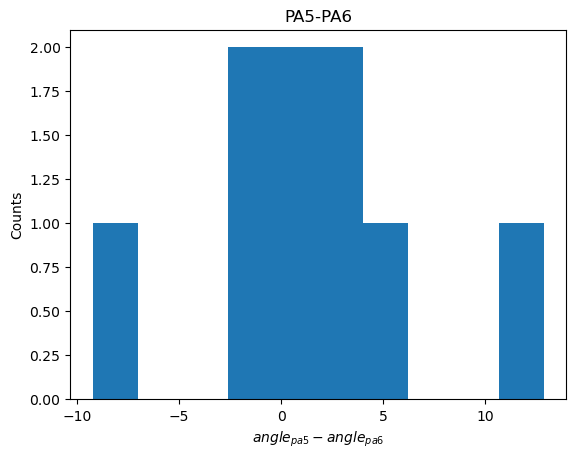

In [27]:
plt.hist(pa4_pa5)
plt.title("PA4-PA5")
plt.ylabel("Counts")
plt.xlabel("$angle_{pa4} - angle_{pa5}$")
plt.show()
plt.close()
plt.hist(pa4_pa6)
plt.title("PA4-PA6")
plt.ylabel("Counts")
plt.xlabel("$angle_{pa4} - angle_{pa6}$")
plt.show()
plt.close()
plt.hist(pa5_pa6)
plt.title("PA5-PA6")
plt.ylabel("Counts")
plt.xlabel("$angle_{pa5} - angle_{pa6}$")
plt.show()
plt.close()

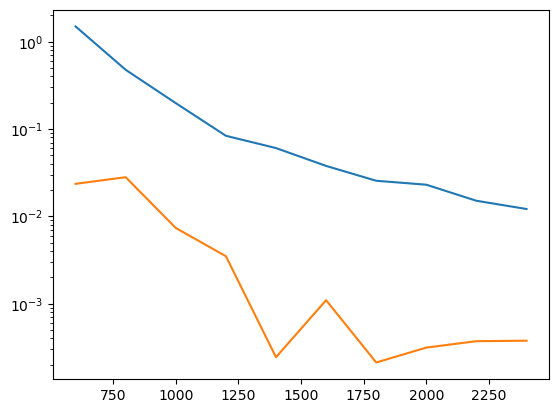

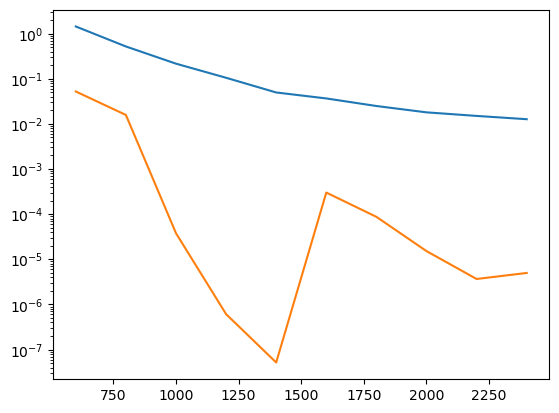

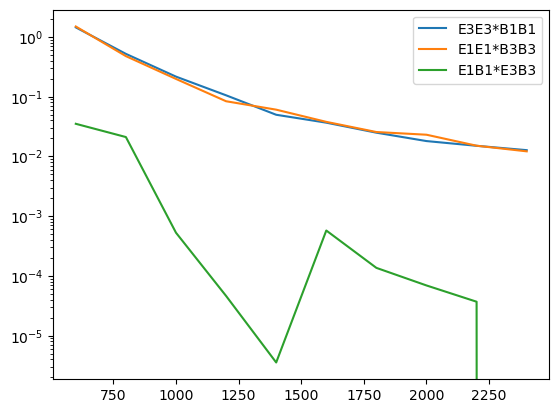

In [18]:
# Testing out an estimator-based way of doing this difference between arrays
# Examining different covariance terms with approximations to see if I can neglect cross-terms
# that I haven't calculated
ell = spectra_dict[maps[0]]['ell']
E1E1 = spectra_dict[maps[0]]['E1xE1'] # Calling the first depth-1 map '1' ('2' is first ref, '4' is second ref)
B3B3 = spectra_dict[maps[1]]['B1xB1'] # Calling the second depth-1 map '3'
E1B1 = spectra_dict[maps[0]]['E1xB1'] # Assuming E1xB1 is similar to E1xB3 since the two depth-1 maps are similar
plt.semilogy(ell,E1E1*B3B3)
plt.semilogy(ell,E1B1**2)
plt.show()
plt.close()

E3E3 = spectra_dict[maps[1]]['E1xE1']
B1B1 = spectra_dict[maps[0]]['B1xB1']
E3B3 = spectra_dict[maps[1]]['E1xB1']
plt.semilogy(ell,E3E3*B1B1)
plt.semilogy(ell,E3B3**2)
plt.show()
plt.close()

plt.semilogy(ell,E3E3*B1B1,label='E3E3*B1B1')
plt.semilogy(ell,E1E1*B3B3,label='E1E1*B3B3')
plt.semilogy(ell,E1B1*E3B3,label='E1B1*E3B3')
plt.legend()
plt.show()
plt.close()

These plots mean that the full covariance would just vanish or be impossible to calculate under the assumptions that I was hoping to make - the last plot in particular shows that I can't neglect the E1E3\*B3B1 term, and if I approximate it as E3E3\*B1B1 (or vice versa), then the whole covariance will vanish. This seems like a dead end for this approximation of the covariance of the difference between the estimators.

In [19]:
import os
import sys
from scipy import optimize as op

In [20]:
def estimator_likelihood(angle, estimator, covariance, ClEE):
    """For a given difference in angle between the depth-1 map (map 1) and the coadd (map 2),
       returns the value of the normalized likelihood for our estimator.
       
       ClEE is the theory EE spectrum from CAMB"""

    numerator = (estimator - ClEE*np.sin(2*angle))**2
    denominator = 2*covariance
    likelihood = np.exp(-np.sum(numerator/denominator))
    return likelihood

def gaussian(x,mean,sigma):
    """Normalized Gaussian for curve_fit"""
    amp = 1.0
    return amp*np.exp(-(x-mean)**2/(2*sigma**2))

def gaussian_fit_curvefit(angles,data):
    """
        Uses scipy.optimize.curve_fit() to fit a Gaussian to the likelihood to
        get the mean and standard deviation.

        Assumes everything is in radians.
    """
    guess = [1.0*np.pi/180.0, 5.0*np.pi/180.0] # Mean=1, stddev=5 worked well for 73 test maps
    popt, pcov = op.curve_fit(gaussian,angles,data,guess,maxfev=50000)
    mean = popt[0]
    std_dev = np.abs(popt[1])
    return mean, std_dev

def sample_likelihood_and_fit(estimator,covariance,theory_ClEE,angle_min_deg=-20.0,angle_max_deg=20.0,
                              num_pts=10000,use_curvefit=True,plot_like=False,output_dir=None,map_fname=None):
    """
       Samples likelihood for a range of angles and returns the best fit for the
       mean and std dev of the resulting Gaussian in degrees.  
       Has the option to do the fitting with scipy.optimize.curve_fit() (set use_curvefit=True)
       or a method using moments of the Gaussian. The moments method is faster but less
       accurate when the likelihood deviates from Gaussianity in any way.
    """
    if(angle_min_deg >= angle_max_deg): 
        raise ValueError("The min angle must be smaller than the max!")
    angles_deg = np.linspace(angle_min_deg,angle_max_deg,num=num_pts)
    angles_rad = np.deg2rad(angles_deg)
    
    bin_sampled_likelihood = [estimator_likelihood(angle,estimator,covariance,theory_ClEE) for angle in angles_rad]
    norm_sampled_likelihood = bin_sampled_likelihood/np.max(bin_sampled_likelihood)
    
    if use_curvefit:
        fit_values = gaussian_fit_curvefit(angles_rad,norm_sampled_likelihood)
        fit_values_deg = [np.rad2deg(fit_values[0]), np.rad2deg(fit_values[1])]
        # Could add some flag or option to redo the fit for a given map if curve_fit() returns
        # a bad stddev value from failing to fit - for now I will leave it so I can see easily by the stddev that it fails
    else:
        fit_values = gaussian_fit_moment(angles_rad,norm_sampled_likelihood)
        fit_values_deg = [np.rad2deg(fit_values[0]), np.rad2deg(fit_values[1])]

    if plot_like:
        map_name = os.path.split(map_fname)[1][:-9] # removing "_map.fits"
        mean = fit_values_deg[0]
        stddev = fit_values_deg[1]
        fig = plt.figure(figsize=(6.4,4.8), layout='constrained')
        plt.plot(angles_deg, norm_sampled_likelihood, 'b.', label='Mean={:1.3f}\n$\sigma$={:1.3f}'.format(mean,stddev))
        plt.axvline(mean,alpha=0.3,color='black')
        # Could also move label to plt.figtext, but legend will auto adjust for me
        plt.plot(angles_deg, gaussian(angles_deg,mean,stddev), 'r', label='Fit Gaussian')
        plt.legend()
        plt.ylabel("Likelihood")
        plt.xlabel("Angles (deg)")
        plt.grid()
        plt.title("Likelihood " + map_name)
        plt.show()
        plt.close()

    return fit_values_deg

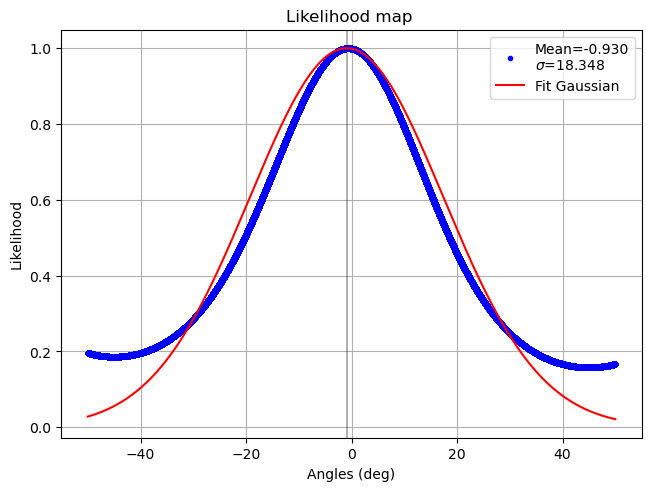

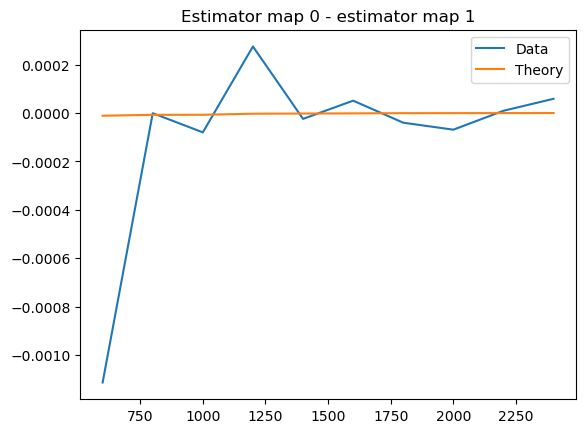

In [21]:
# Next main option - just neglect cross-term and add the two covariances together and see what happens
# testing for maps 0 and 1
test_est_diff = spectra_dict[maps[0]]['estimator'] - spectra_dict[maps[1]]['estimator']
test_cov_sum = spectra_dict[maps[0]]['covariance'] + spectra_dict[maps[1]]['covariance']
test_CAMB_EE = spectra_dict[maps[0]]['CAMB_EE']
results = sample_likelihood_and_fit(test_est_diff,test_cov_sum,test_CAMB_EE,angle_min_deg=-50.0,
                                    angle_max_deg=50.0,num_pts=200000,plot_like=True,map_fname='map 0 - map 1')
plt.plot(ell,test_est_diff,label='Data')
plt.plot(ell,test_CAMB_EE*np.sin(2*np.deg2rad(results[0])),label='Theory')
plt.title("Estimator map 0 - estimator map 1")
plt.legend()
plt.show()
plt.close()

In [22]:
print(maps[6])
print(maps[7])

depth1_1494479992_pa4_f150_map.fits
depth1_1494479992_pa5_f150_map.fits


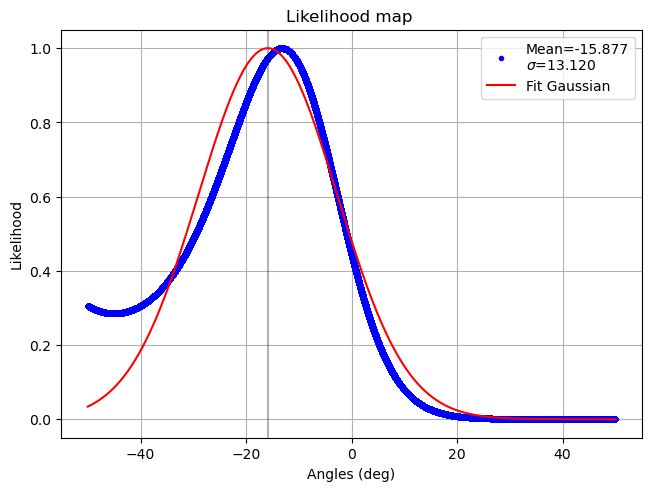

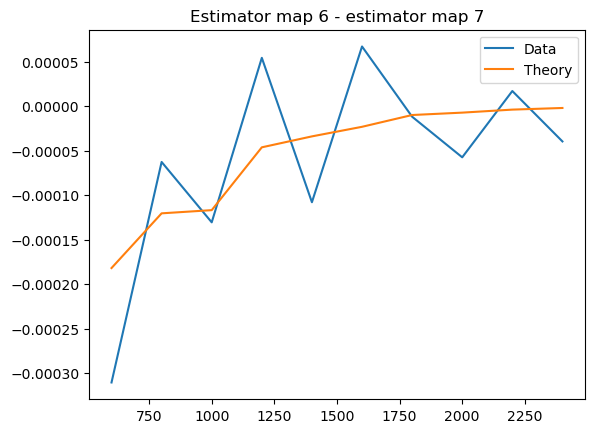

In [23]:
# Trying another set of good PA4 and PA5 maps for comparison
test_est_diff = spectra_dict[maps[6]]['estimator'] - spectra_dict[maps[7]]['estimator']
test_cov_sum = spectra_dict[maps[6]]['covariance'] + spectra_dict[maps[7]]['covariance']
test_CAMB_EE = spectra_dict[maps[0]]['CAMB_EE']
results = sample_likelihood_and_fit(test_est_diff,test_cov_sum,test_CAMB_EE,angle_min_deg=-50.0,
                                    angle_max_deg=50.0,num_pts=200000,plot_like=True,map_fname='map 0 - map 1')
plt.plot(ell,test_est_diff,label='Data')
plt.plot(ell,test_CAMB_EE*np.sin(2*np.deg2rad(results[0])),label='Theory')
plt.title("Estimator map 6 - estimator map 7")
plt.legend()
plt.show()
plt.close()

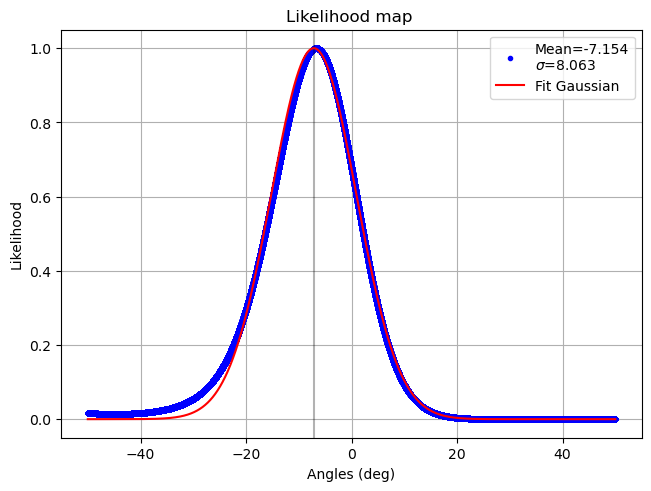

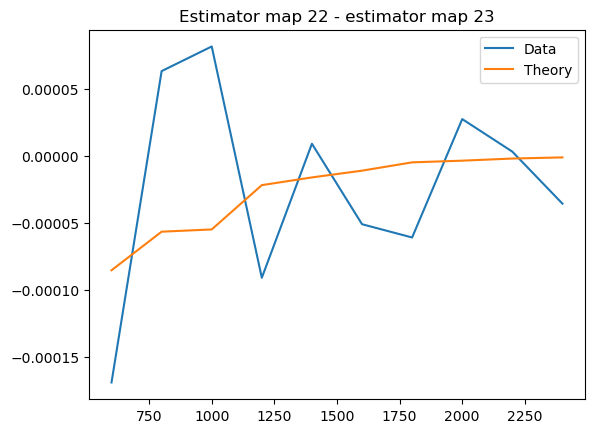

In [24]:
# One more for fun - both in very good category
test_est_diff = spectra_dict[maps[22]]['estimator'] - spectra_dict[maps[23]]['estimator']
test_cov_sum = spectra_dict[maps[22]]['covariance'] + spectra_dict[maps[23]]['covariance']
test_CAMB_EE = spectra_dict[maps[0]]['CAMB_EE']
results = sample_likelihood_and_fit(test_est_diff,test_cov_sum,test_CAMB_EE,angle_min_deg=-50.0,
                                    angle_max_deg=50.0,num_pts=200000,plot_like=True,map_fname='map 0 - map 1')
plt.plot(ell,test_est_diff,label='Data')
plt.plot(ell,test_CAMB_EE*np.sin(2*np.deg2rad(results[0])),label='Theory')
plt.title("Estimator map 22 - estimator map 23")
plt.legend()
plt.show()
plt.close()

In [53]:
# Testing out likelihood residual as quantitative way of flagging bad fits
def sample_likelihood_and_fit(estimator,covariance,theory_ClEE,angle_min_deg=-20.0,angle_max_deg=20.0,
                              num_pts=10000,use_curvefit=True,plot_like=False,output_dir=None,map_fname=None):
    """
       Samples likelihood for a range of angles and returns the best fit for the
       mean and std dev of the resulting Gaussian in degrees.  
       Has the option to do the fitting with scipy.optimize.curve_fit() (set use_curvefit=True)
       or a method using moments of the Gaussian. The moments method is faster but less
       accurate when the likelihood deviates from Gaussianity in any way.
    """
    if(angle_min_deg >= angle_max_deg): 
        raise ValueError("The min angle must be smaller than the max!")
    angles_deg = np.linspace(angle_min_deg,angle_max_deg,num=num_pts)
    angles_rad = np.deg2rad(angles_deg)
    
    bin_sampled_likelihood = [estimator_likelihood(angle,estimator,covariance,theory_ClEE) for angle in angles_rad]
    norm_sampled_likelihood = bin_sampled_likelihood/np.max(bin_sampled_likelihood)
    
    if use_curvefit:
        fit_values = gaussian_fit_curvefit(angles_rad,norm_sampled_likelihood)
        fit_values_deg = [np.rad2deg(fit_values[0]), np.rad2deg(fit_values[1])]
        # Could add some flag or option to redo the fit for a given map if curve_fit() returns
        # a bad stddev value from failing to fit - for now I will leave it so I can see easily by the stddev that it fails
    else:
        fit_values = gaussian_fit_moment(angles_rad,norm_sampled_likelihood)
        fit_values_deg = [np.rad2deg(fit_values[0]), np.rad2deg(fit_values[1])]

    mean = fit_values_deg[0]
    stddev = fit_values_deg[1]
    residual = norm_sampled_likelihood - gaussian(angles_rad,fit_values[0],fit_values[1])
    # finding indices of +/- 1 sigma around mean
    minus_sigma_idx = np.searchsorted(angles_rad,fit_values[0]-fit_values[1])
    plus_sigma_idx = np.searchsorted(angles_rad,fit_values[0]+fit_values[1])
    print(minus_sigma_idx, plus_sigma_idx)
    print(angles_deg[minus_sigma_idx], angles_deg[plus_sigma_idx])
    residual_rms = np.sqrt(np.mean(residual[minus_sigma_idx:plus_sigma_idx]**2)) # rms not as good b/c it squares small thing
    residual_sum = np.sum(np.abs(residual[minus_sigma_idx:plus_sigma_idx]))
    
    if plot_like:
        map_name = os.path.split(map_fname)[1][:-9] # removing "_map.fits"
        fig = plt.figure(figsize=(6.4,4.8), layout='constrained')
        plt.plot(angles_deg, norm_sampled_likelihood, 'b.', label='Mean={:1.3f}\n$\sigma$={:1.3f}'.format(mean,stddev))
        plt.axvline(mean,alpha=0.3,color='black')
        # Could also move label to plt.figtext, but legend will auto adjust for me
        plt.plot(angles_deg, gaussian(angles_deg,mean,stddev), 'r', label='Fit Gaussian')
        plt.plot(angles_deg, residual, 'gray', label='Residual')
        plt.legend()
        plt.ylabel("Likelihood")
        plt.xlabel("Angles (deg)")
        plt.grid()
        plt.title("Likelihood " + map_name)
        plt.show()
        plt.close()

    return fit_values_deg, residual_rms, residual_sum

73843 126645
-13.078315391576957 13.322816614083074


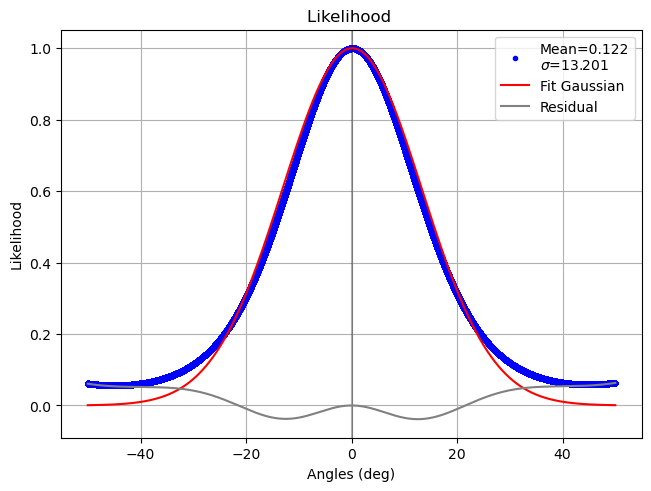

0.024261484023711873 1056.7386801201033


In [54]:
map_num = 0
results,res_rms,res_sum = sample_likelihood_and_fit(spectra_dict[maps[map_num]]['estimator'],
                                                     spectra_dict[maps[map_num]]['covariance'],
                                                     test_CAMB_EE,angle_min_deg=-50.0,
                                    angle_max_deg=50.0,num_pts=200000,plot_like=True,map_fname='map '+str(map_num))
print(res_rms, res_sum)

73843 126645


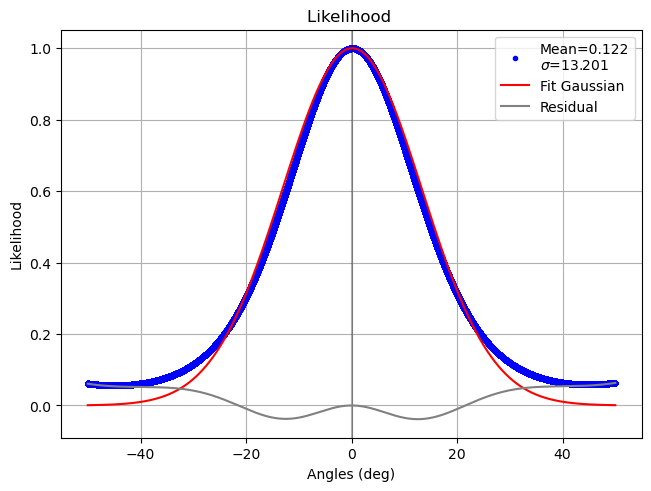

0.024261484023711873 1056.7386801201033
93949 129419


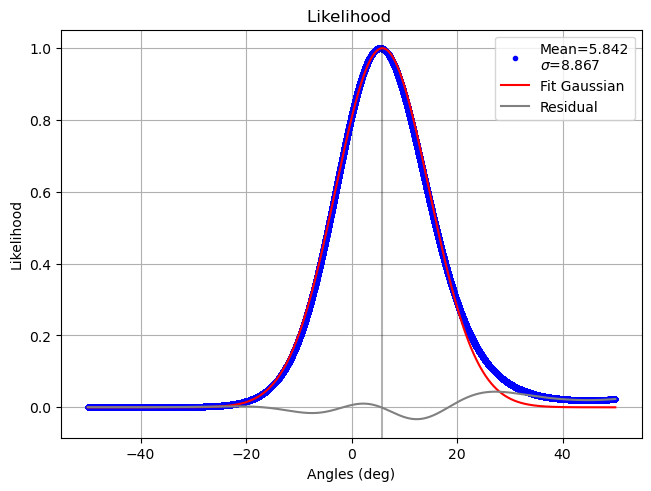

0.01856255056029134 519.6485310639981
91989 137290


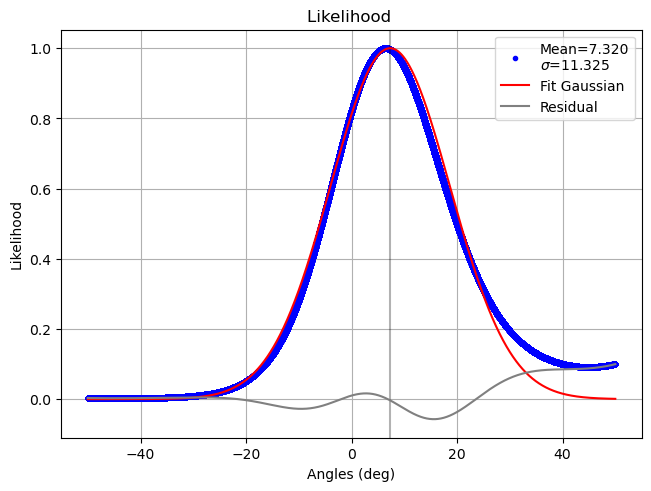

0.032126121692952085 1140.3211468768138
0 136811


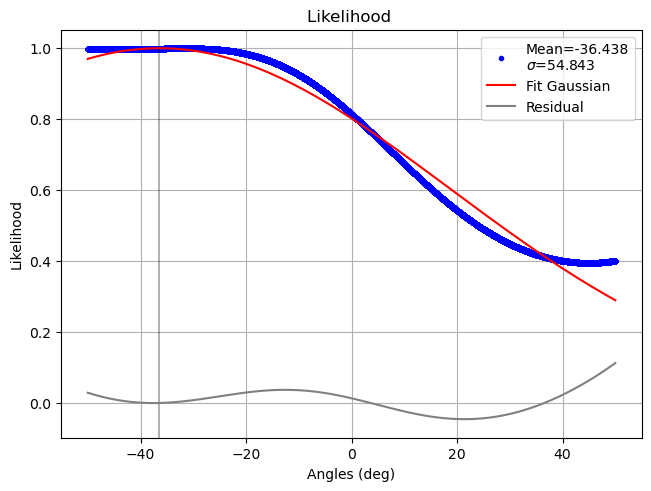

0.023313460734505582 2620.009074974075
98035 98035


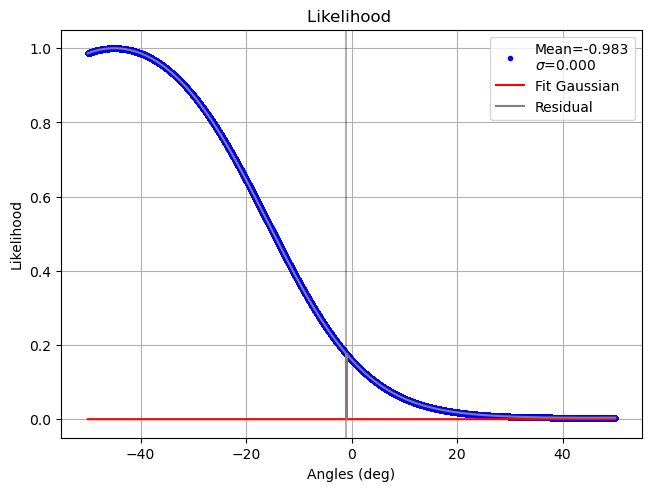

nan 0.0
46209 157335


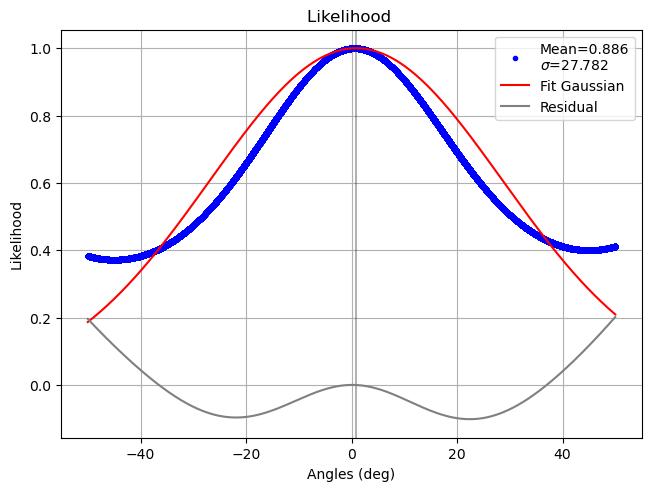

0.06888617836154484 6521.501847947606
75796 107002


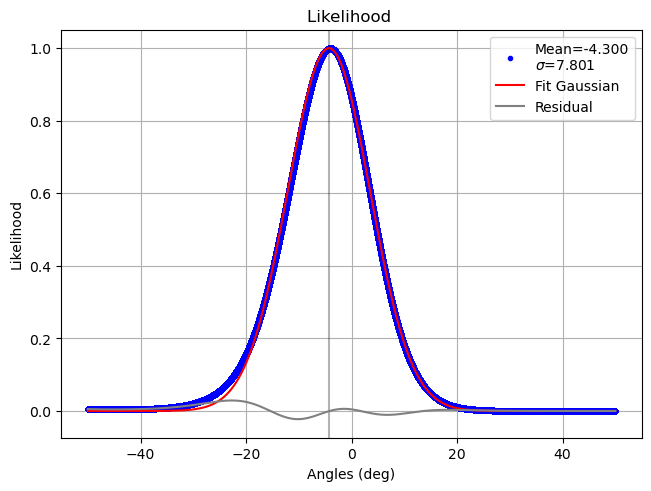

0.012407410990617627 299.447741775603
111049 140225


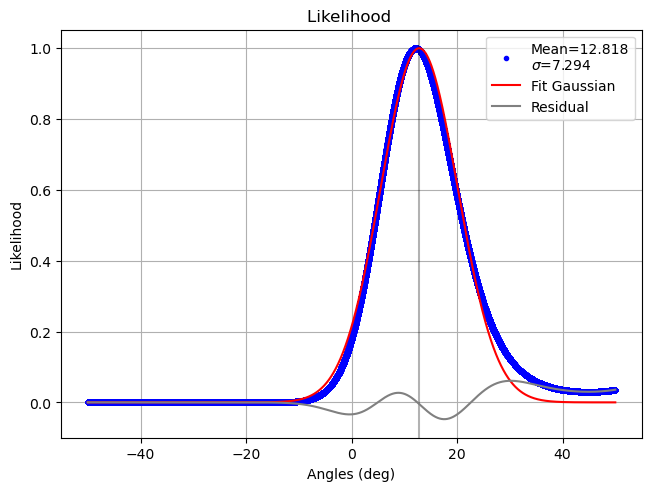

0.029846786126820266 774.969424295454
103662 130620


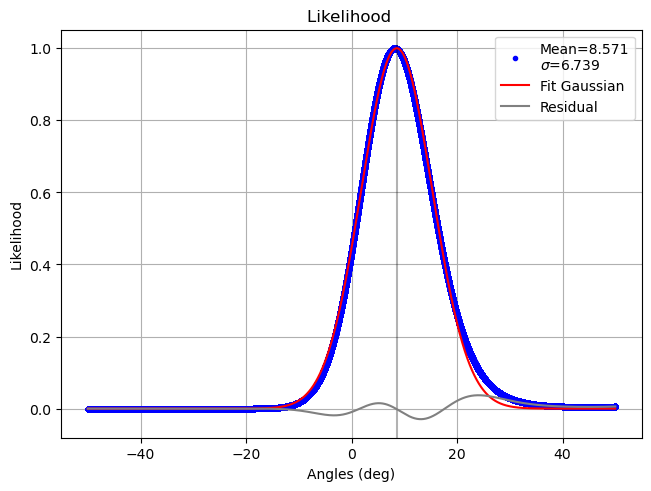

0.017855694696821568 419.33248929864743
0 69480


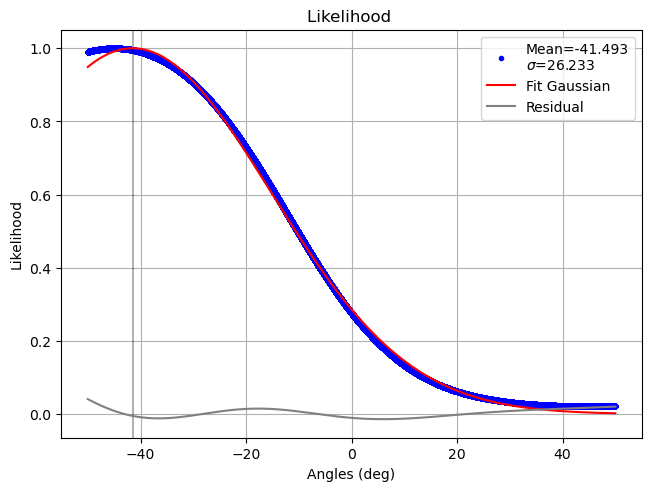

0.013269068847266034 755.0369829602961
97164 138273


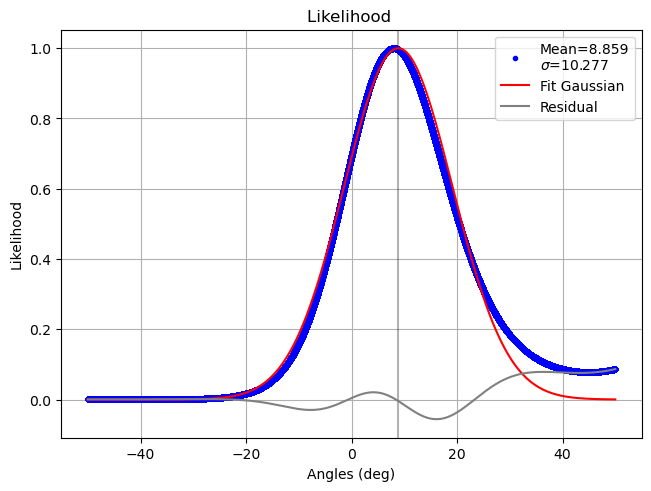

0.032406441412276776 1086.666335660026
95465 95465


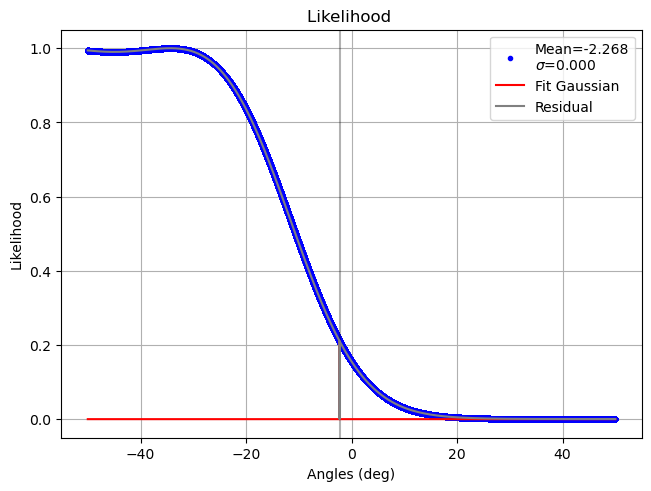

nan 0.0
122804 200000


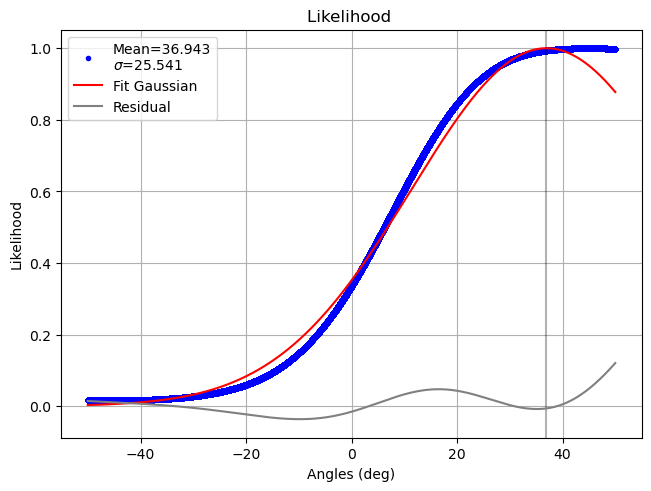

0.040965234936714175 2414.3049378286246
66728 128893


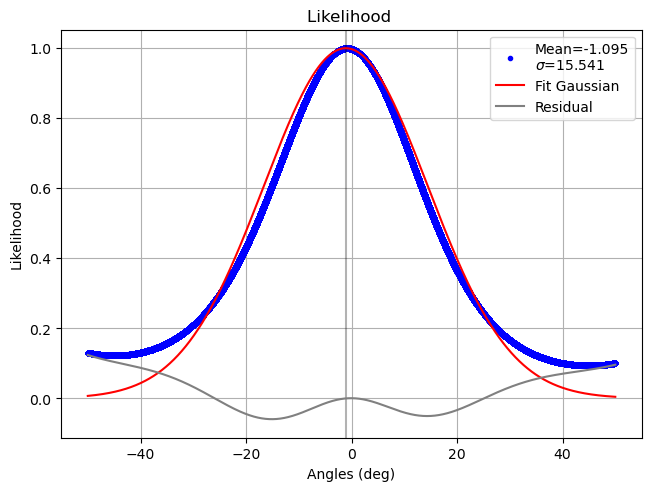

0.03558213024802458 1810.8201549795085
55871 134712


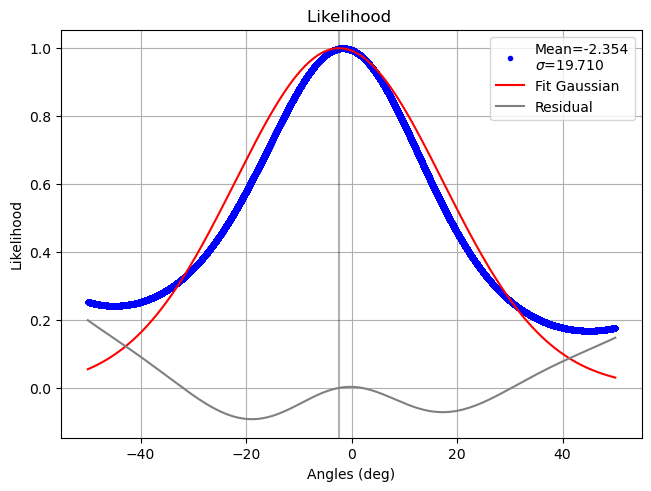

0.05563063249236211 3578.563028617097
135007 200000


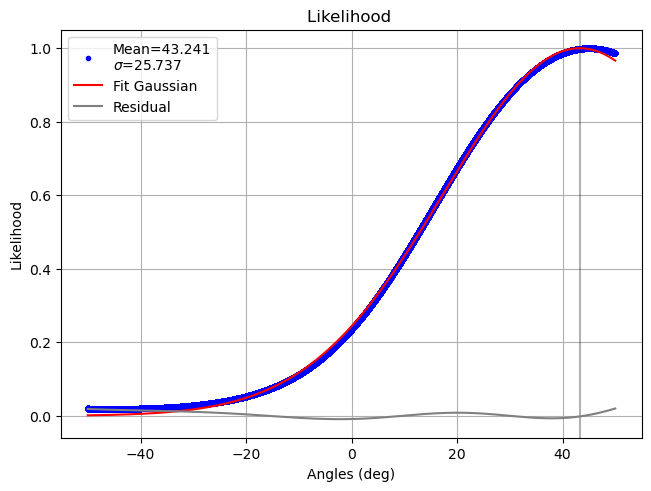

0.0068887519604504234 379.88289672690655
49106 122081


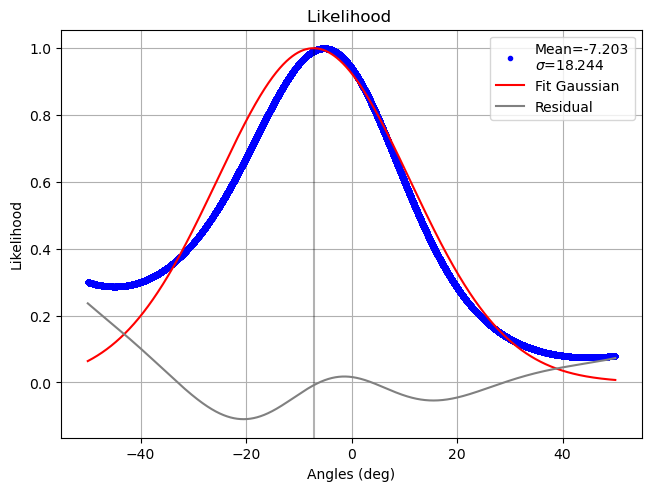

0.06149568331085429 3446.1205901909575
93970 147866


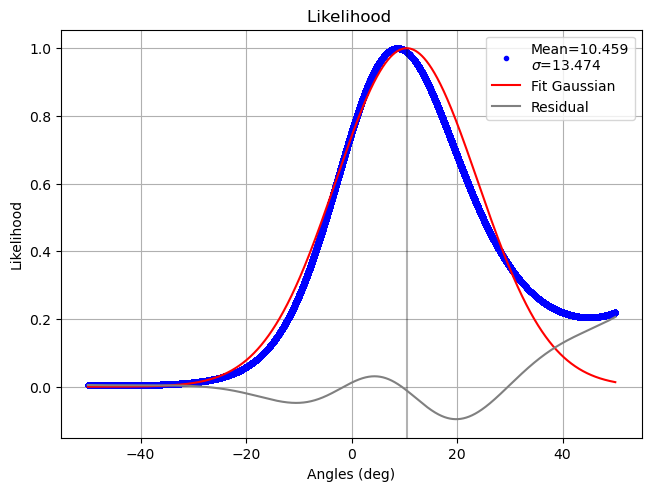

0.05542008719703338 2393.503626901408
99359 141954


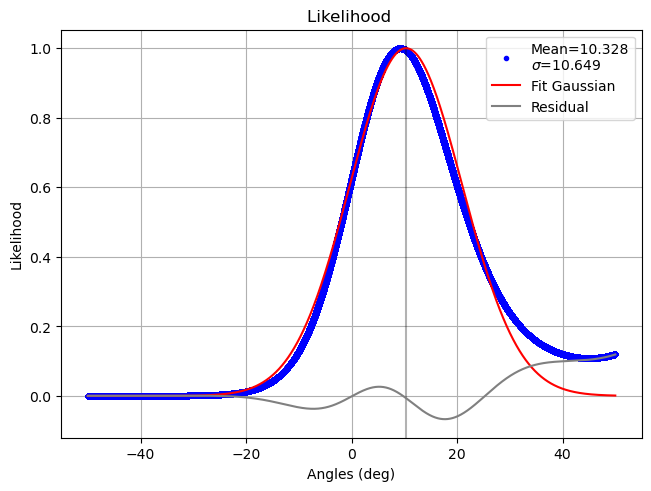

0.0393414699903282 1385.8489707149051
61656 92956


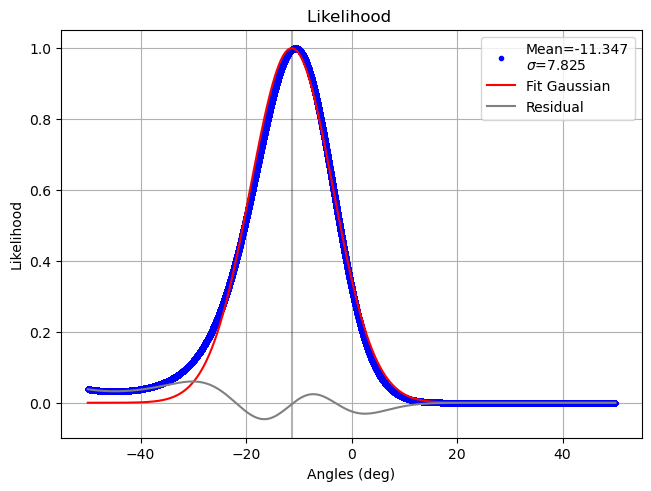

0.028513434565759742 782.3694655420968
86720 107332


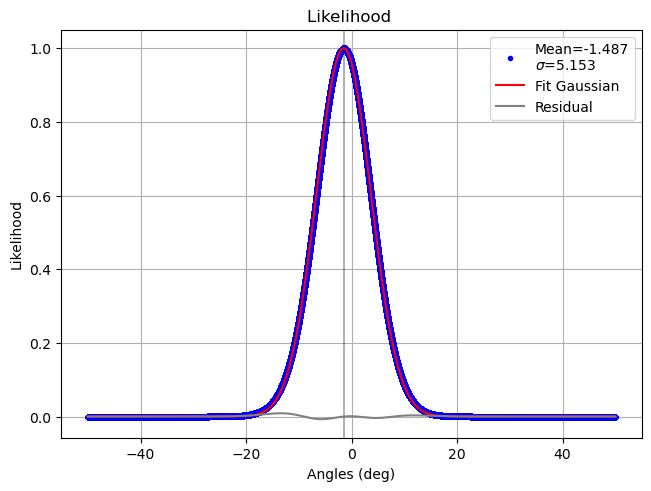

0.0038595916126331975 60.60911912042883
84564 101106


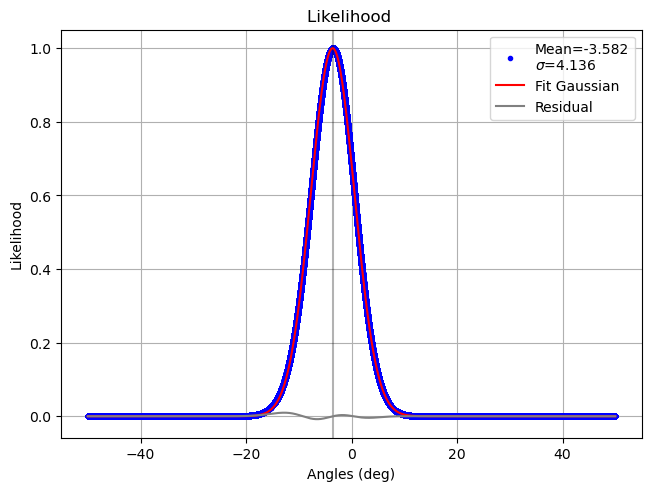

0.004559534634279981 62.66062840556363
83468 105681


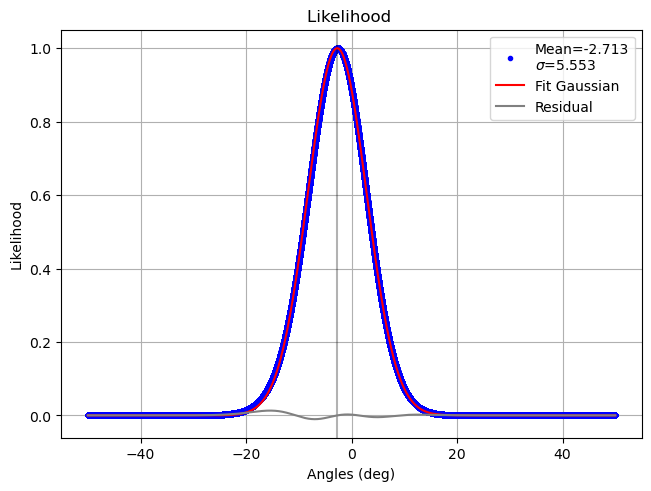

0.005637468589460613 95.88213543616331
91160 110799


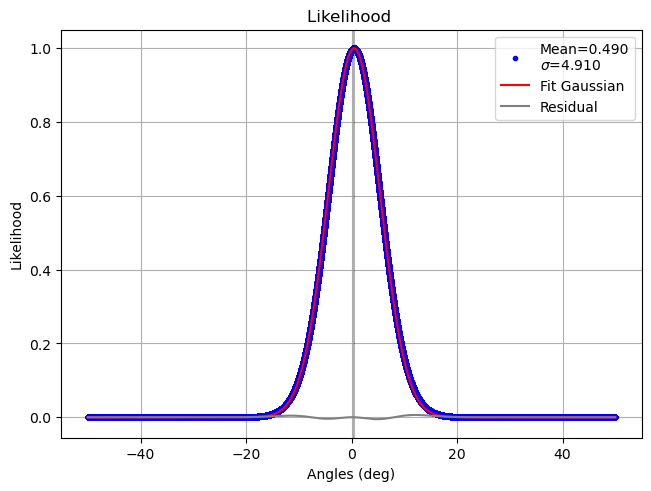

0.002996381288220952 47.52989088255444
88166 101557


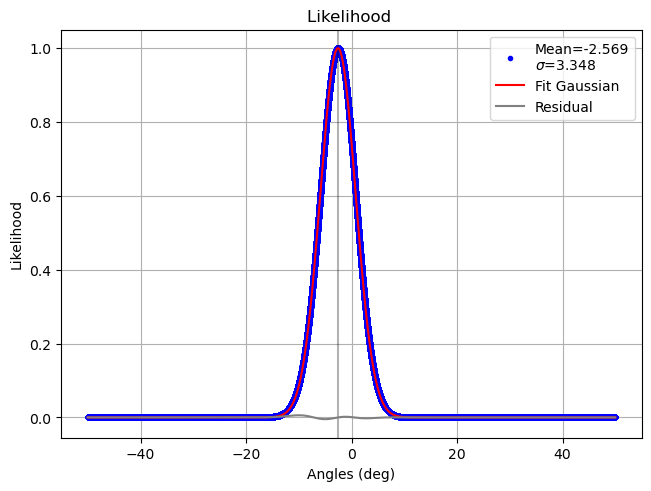

0.002696235174730119 29.4198377995045
84785 108197


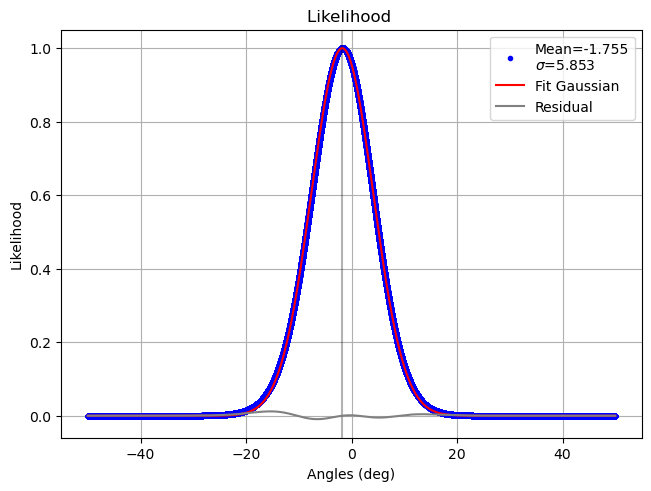

0.005077749257021881 90.42516238868407
105814 122626


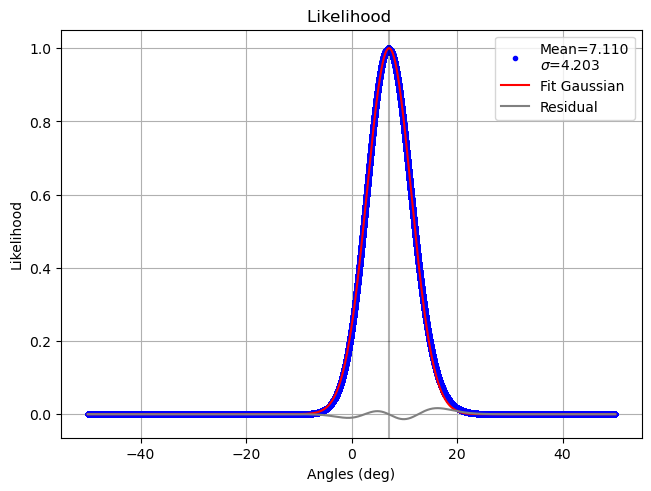

0.008613840920797622 130.24439408597948
107133 120367


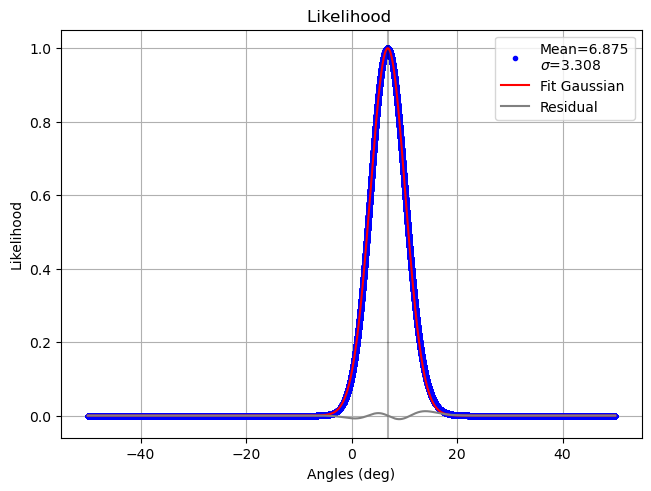

0.006421757861912808 77.4249142684752
73747 104480


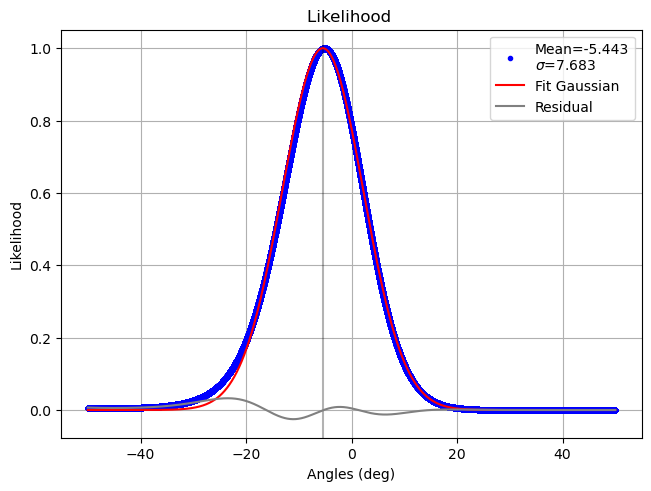

0.014295859620974748 351.15833955302315
90883 110731


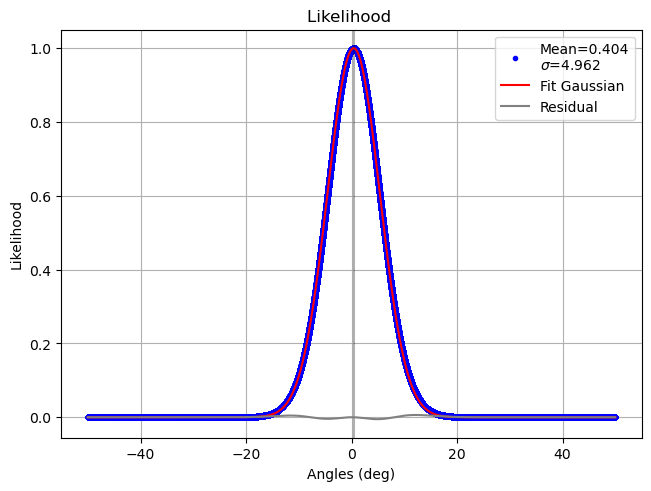

0.003036589755305471 48.965877025707016
108691 129825


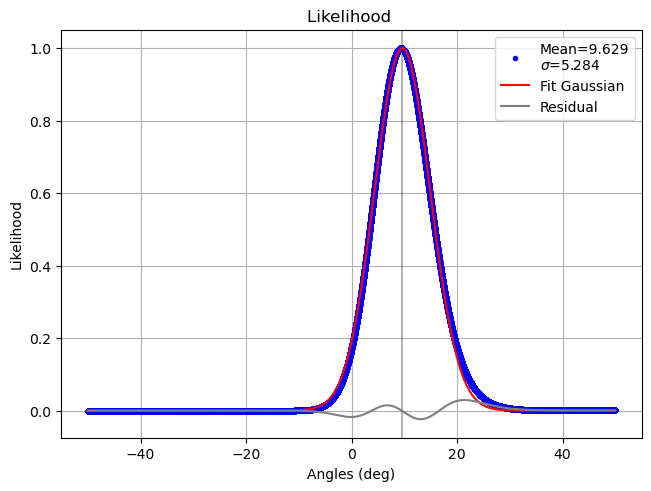

0.015081734610886303 286.957185903702
0 88256


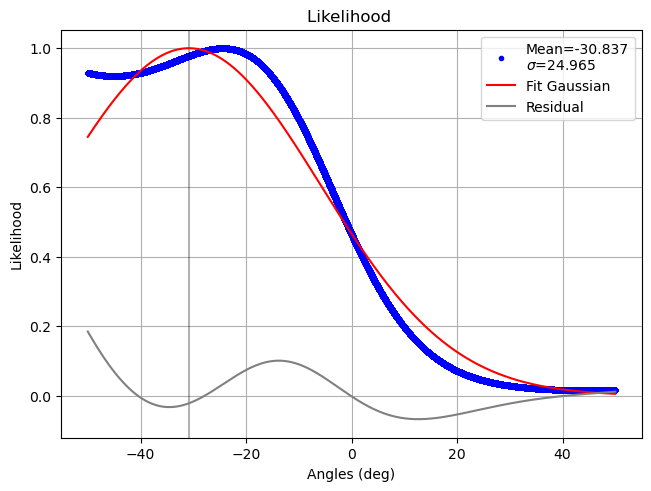

0.07098420267662445 5150.682146527435
111434 196942


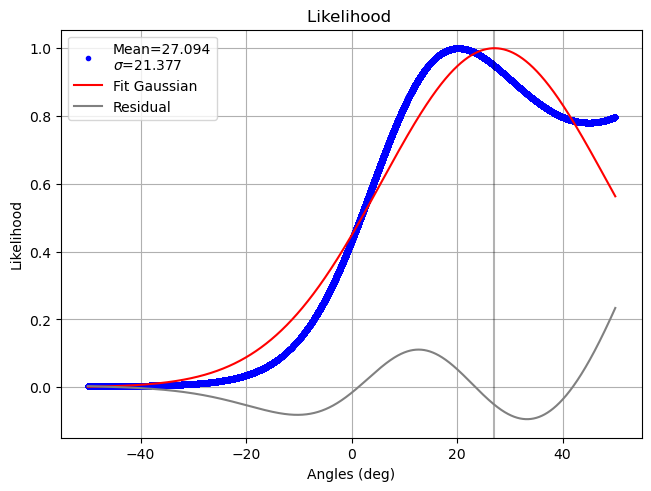

0.08067018700504737 6189.871008900496
104548 104548


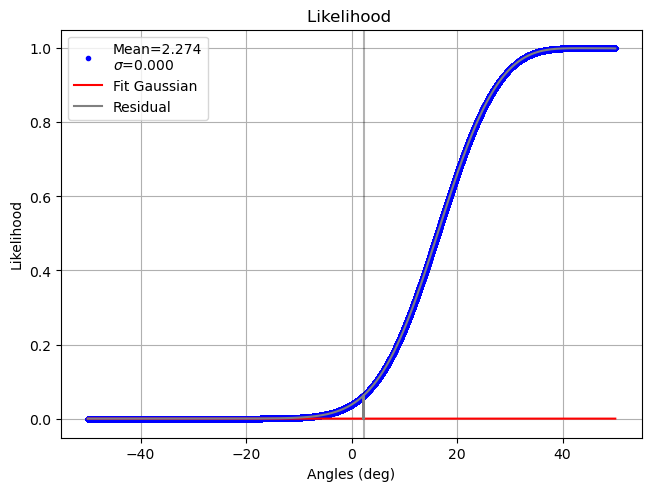

nan 0.0
0 86933


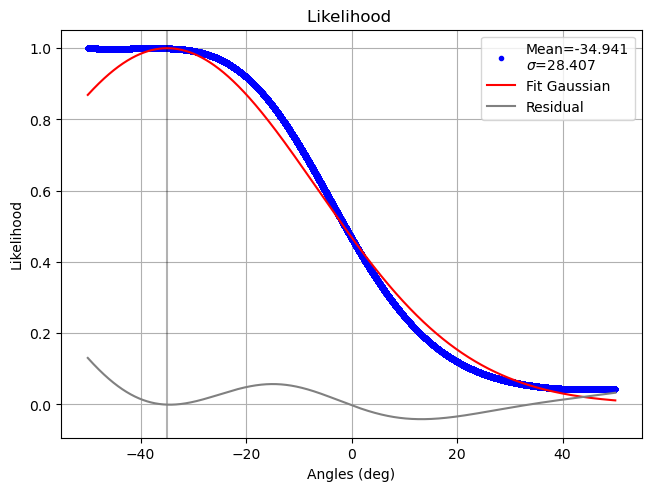

0.04749045299911911 3297.453654989064
35929 142370


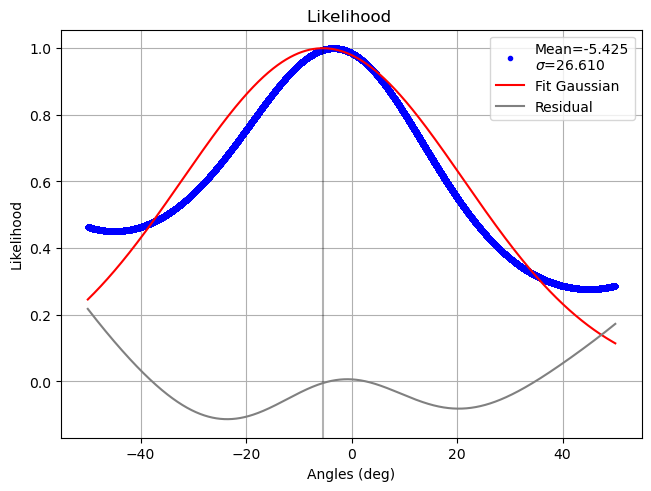

0.06814763719952417 5984.982399699443
8547 123219


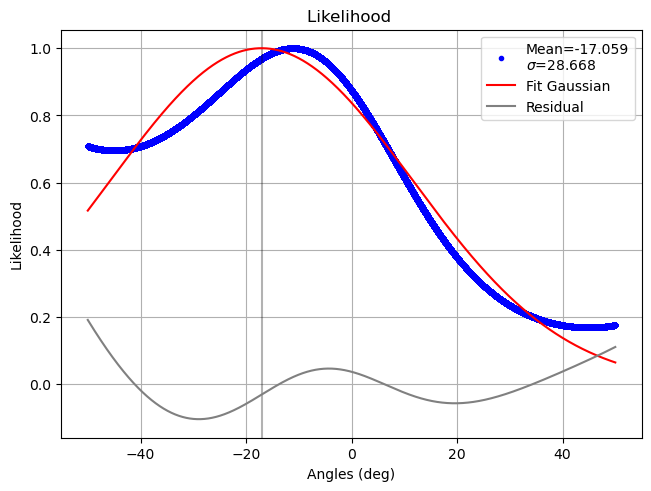

0.05660933547079806 5405.400639623495
97459 121826


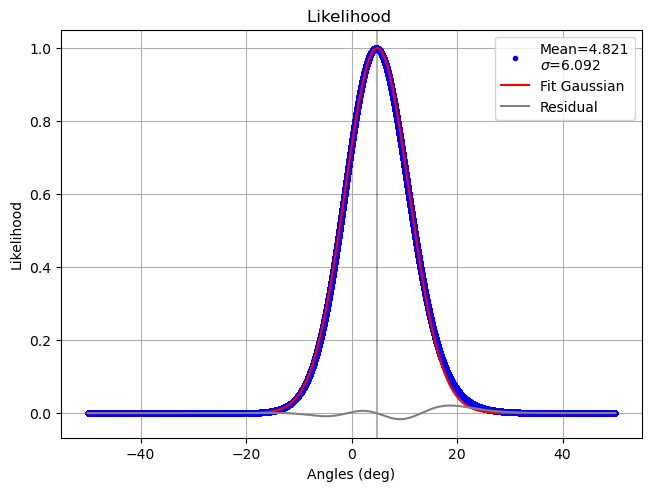

0.009480412327313295 188.43281390111383
96141 111503


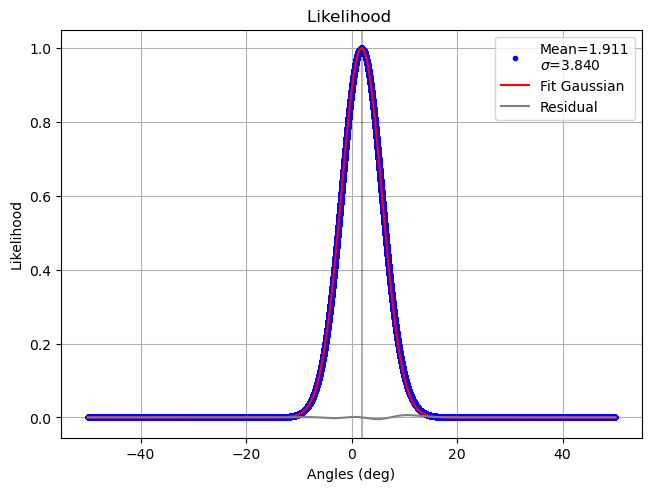

0.0026739698434878707 31.521735608570815
66313 89895


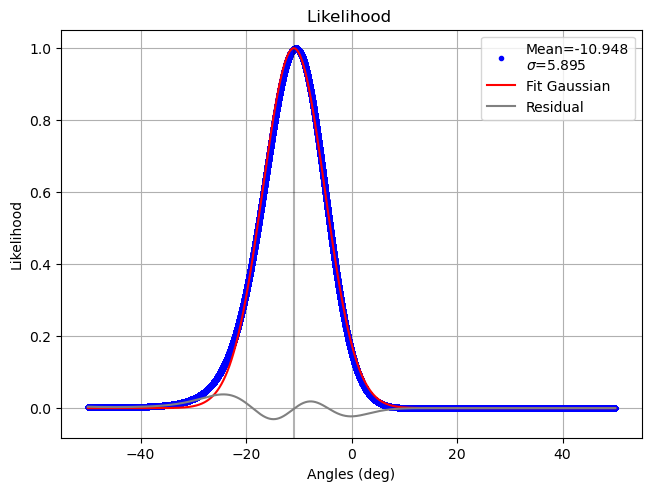

0.019546250906476114 414.3620672746143
109060 193250


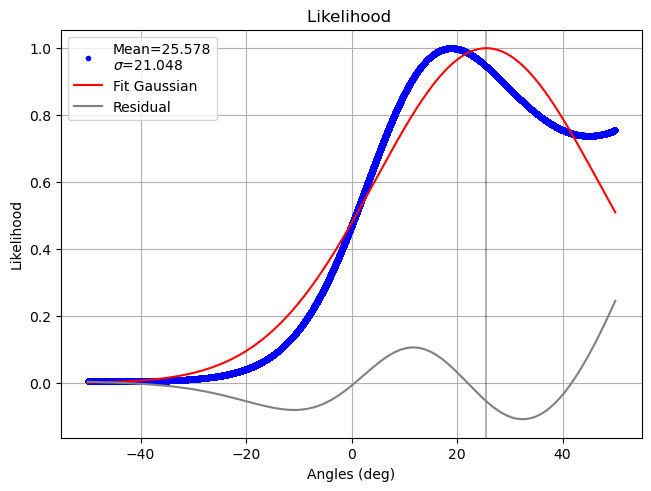

0.07857127743637869 6030.585402275429
45759 101456


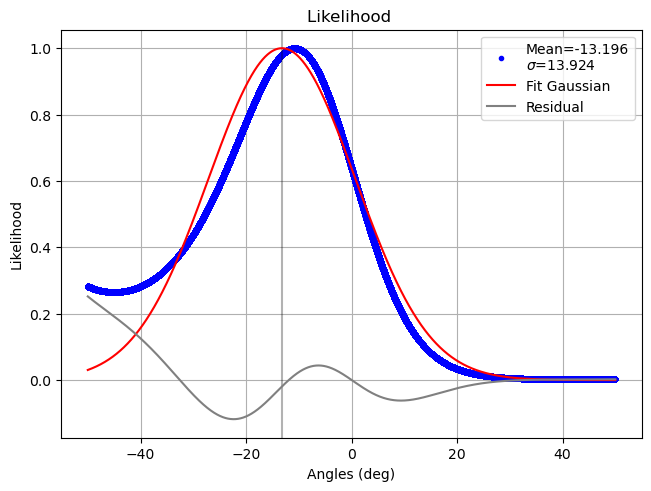

0.06996430255887157 3220.146098995226
92864 146075


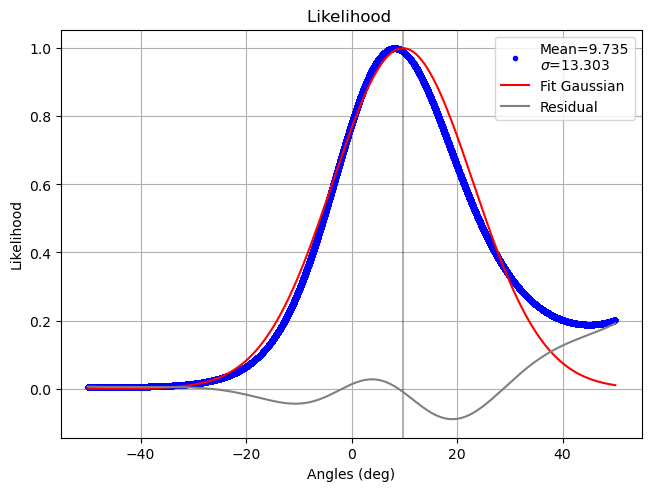

0.05139423962888835 2173.5972133530954
107932 107932


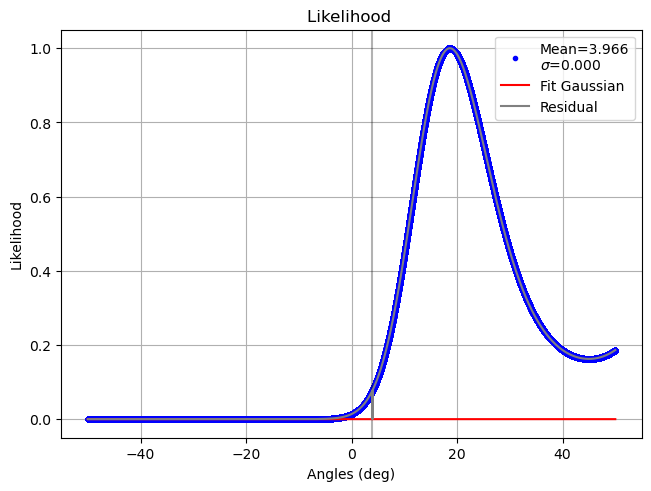

nan 0.0
89430 103034


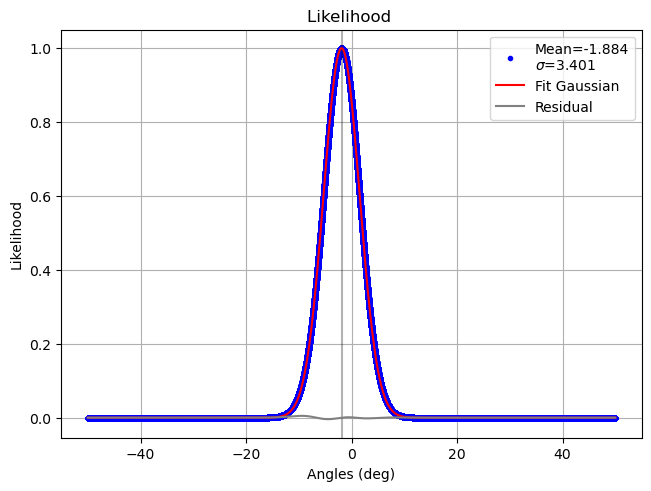

0.002225258420224637 23.496492905761485
88533 101679


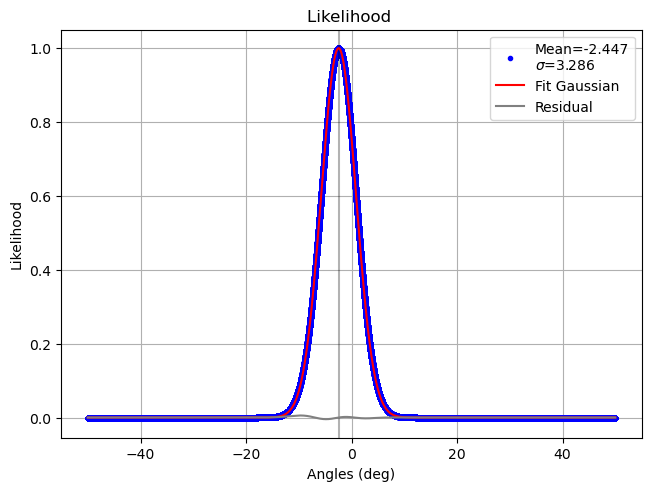

0.002538413974074708 27.0559129046363
79995 91969


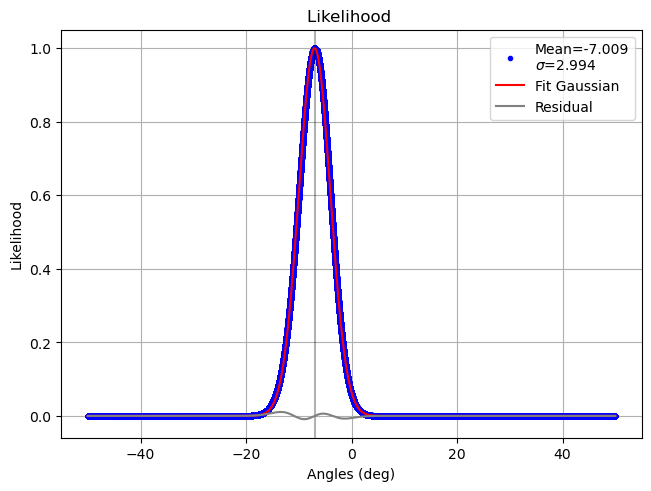

0.005886529748008136 64.54999270067404
89482 99115


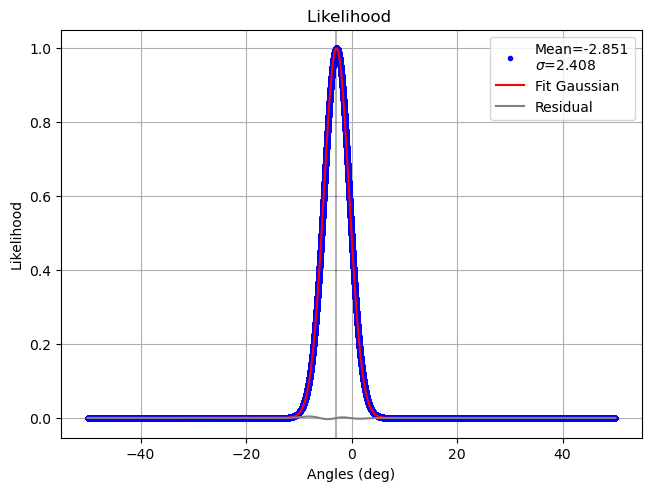

0.0019785846606567652 16.651215129716107
87775 96420


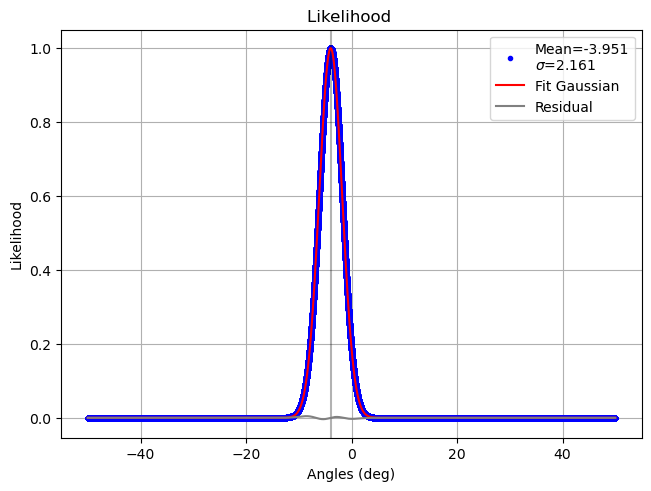

0.002375980141747436 18.629473397163572
101545 101545


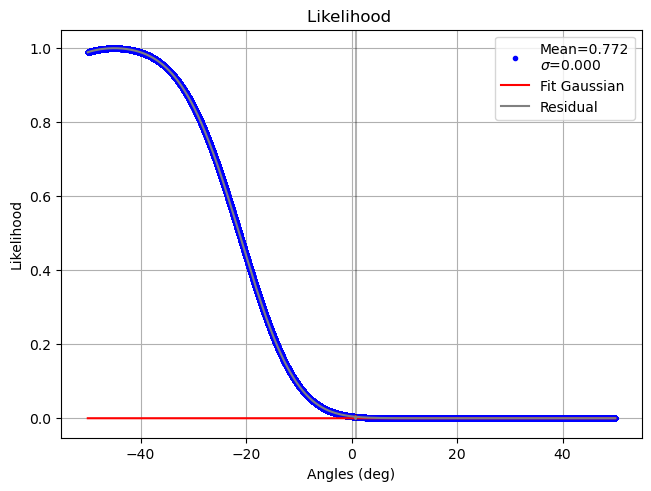

nan 0.0
101307 122744


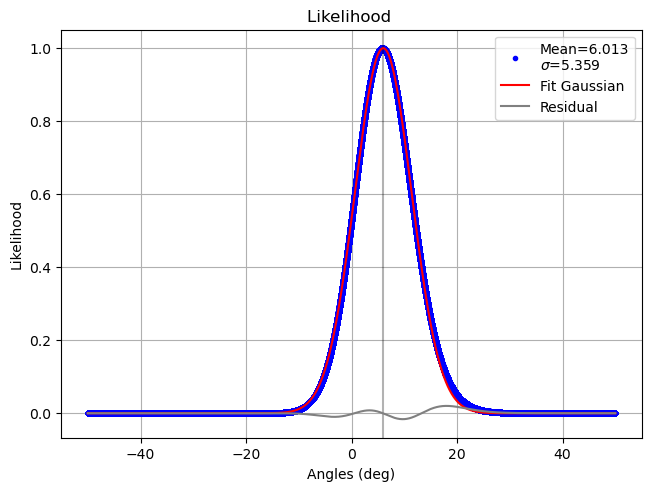

0.009726498928099063 179.85013544960228
0 172780


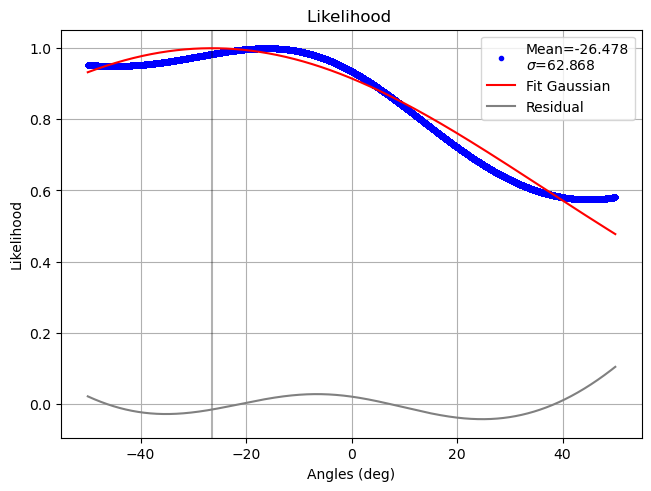

0.024511056302324946 3734.2148939089275
0 148918


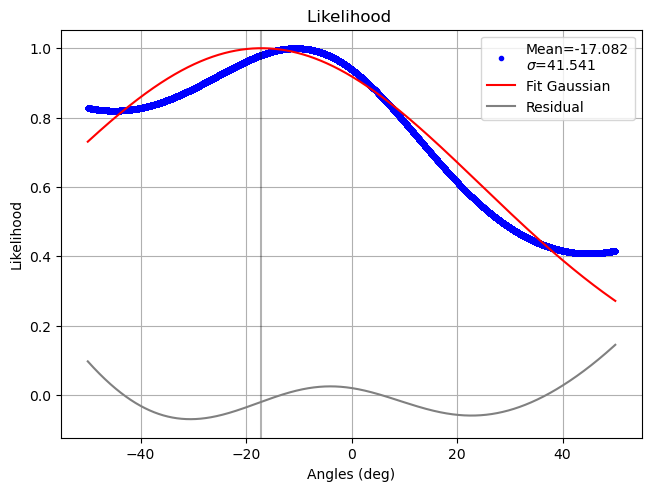

0.042071330929757775 5311.792289426091
108675 126316


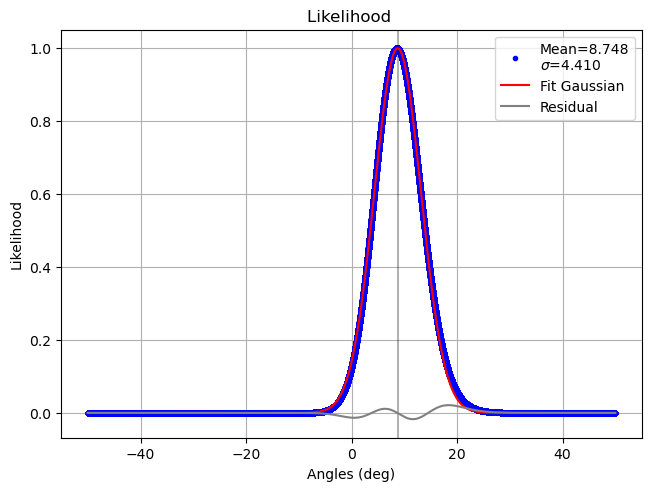

0.01117792917050018 178.78640961775685
94551 102431


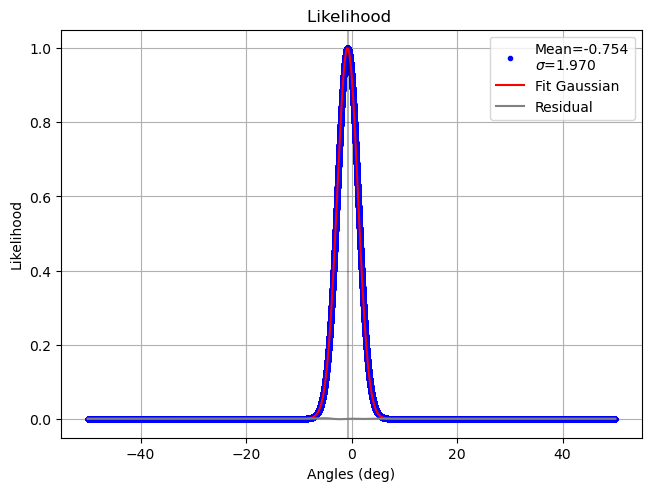

0.0006110708706925648 3.646437666048956
0 156874


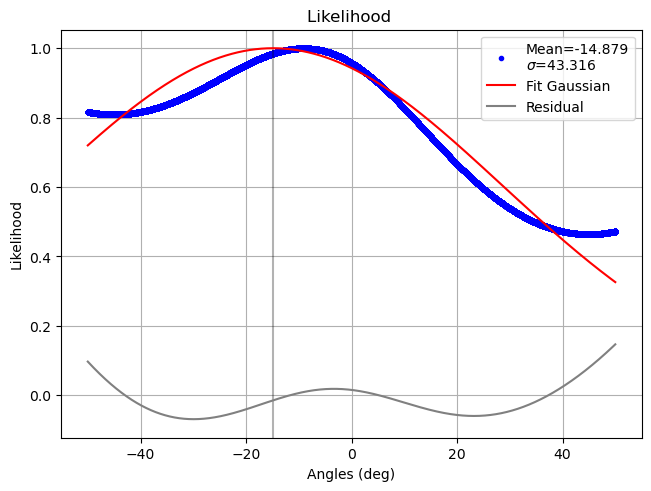

0.04295473516810981 5680.319147653865
13235 115826


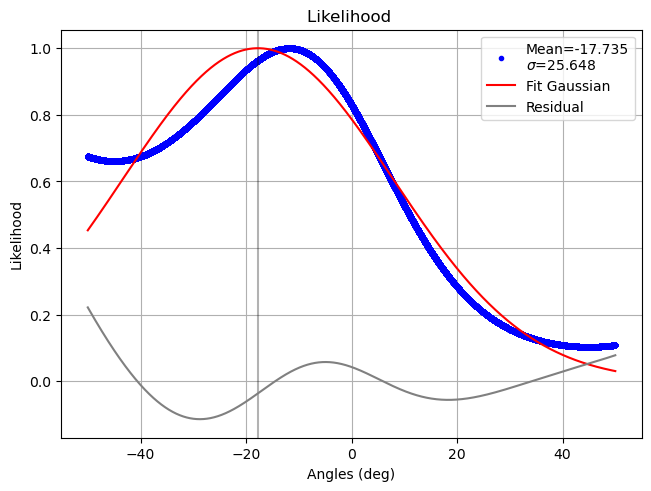

0.06353343718705154 5483.226808636104
63756 99904


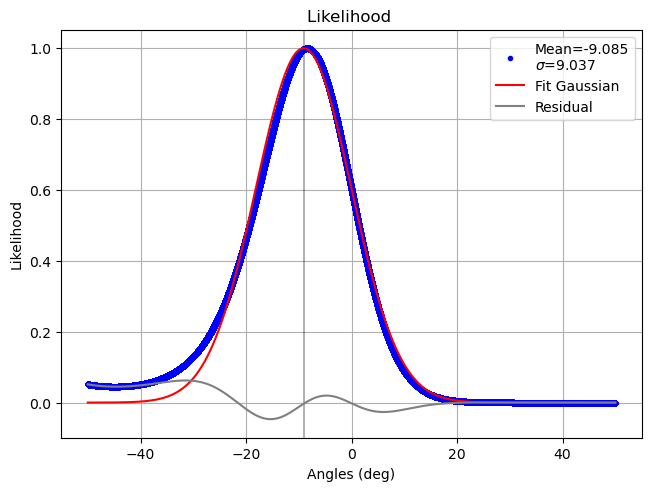

0.02760251933155561 835.4220411451911
100292 137427


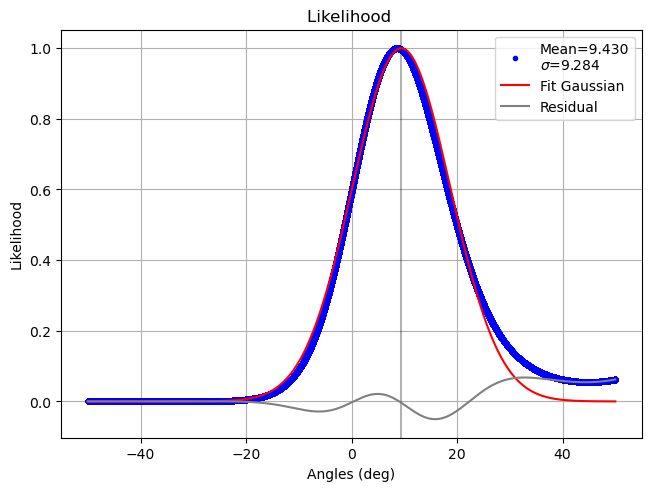

0.029673344518628356 922.7202538122112
73292 189520


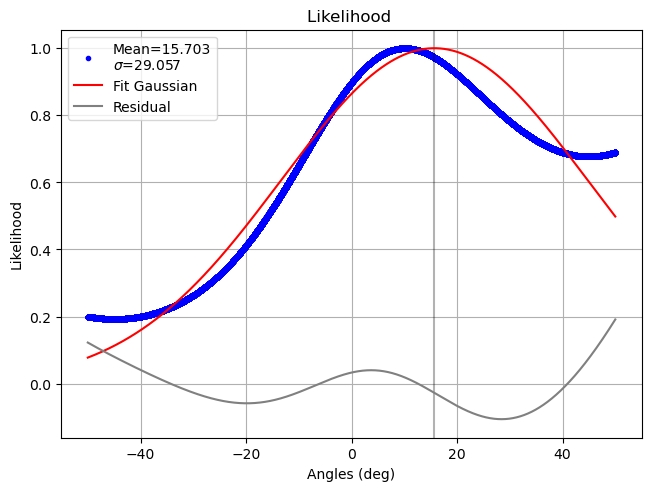

0.056401099984317374 5370.534750113238
56084 132297


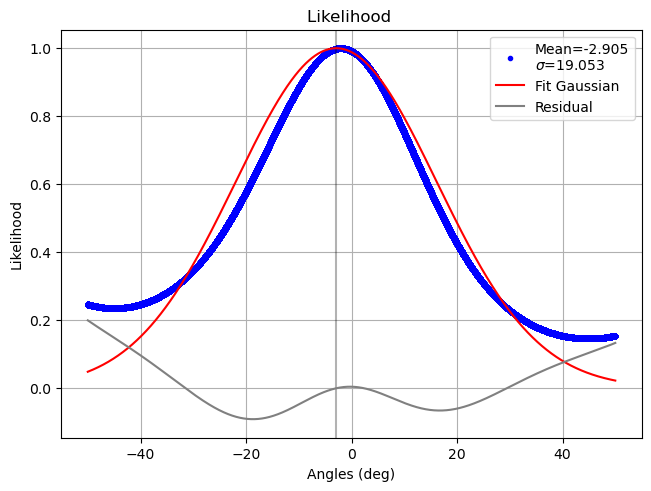

0.05390594118399238 3311.3073983386735
63572 85846


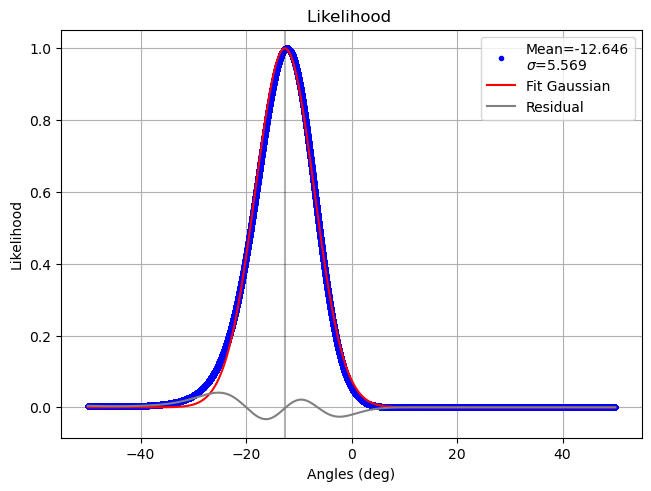

0.021446457451301307 433.52503773542537
63434 85815


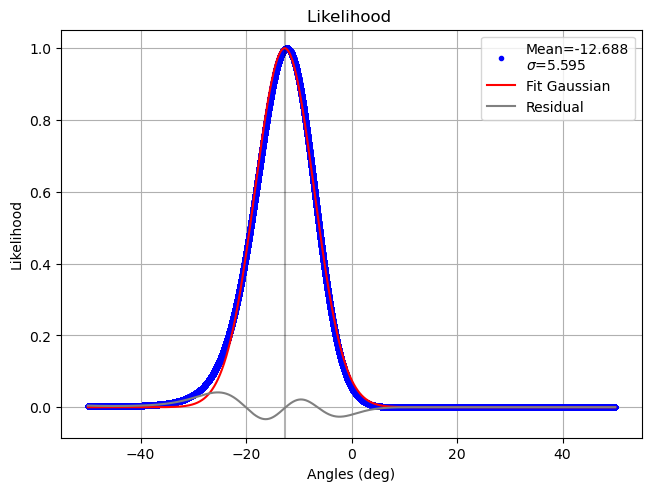

0.02164364922825835 439.53794495086606
7295 122277


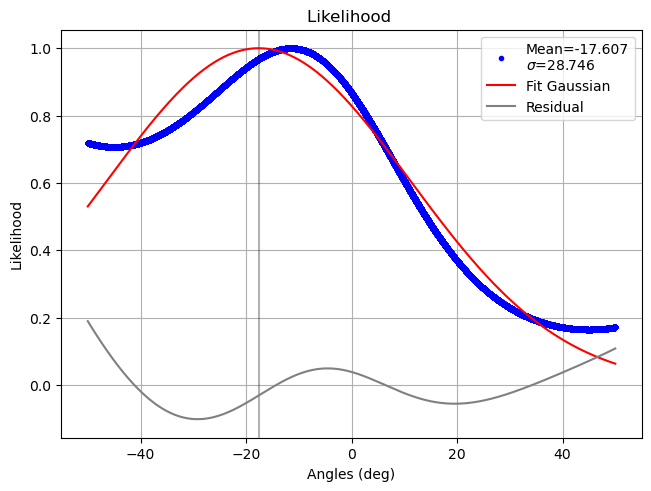

0.05652327836036958 5449.607281497142
52255 109593


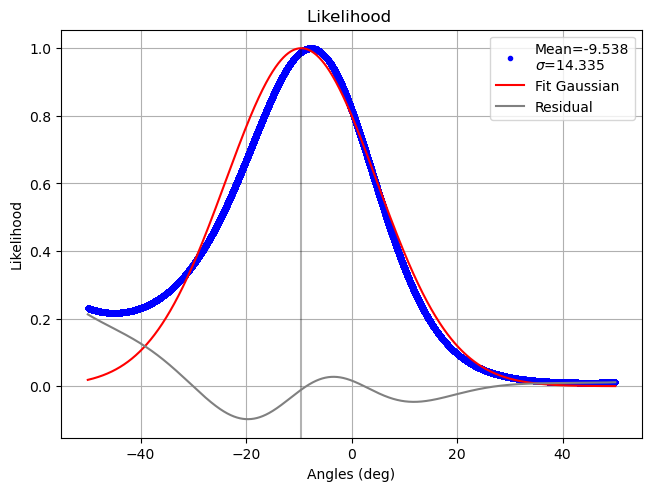

0.0557566442357501 2516.2344315905684
51070 119566


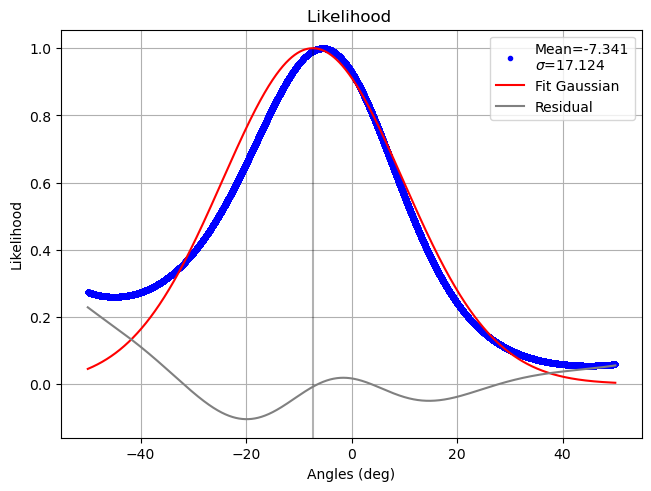

0.05846271136554801 3065.476886480588
91032 137975


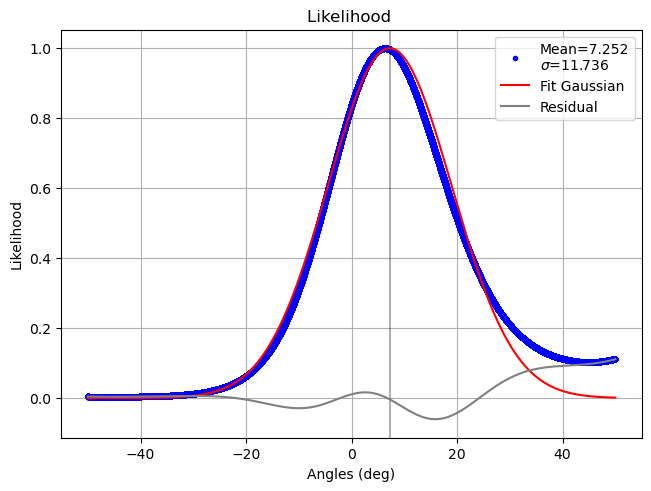

0.03378501960225096 1235.6165680875233


In [50]:
map_nums = np.arange(73)
for map_num in map_nums:
    if spectra_dict[maps[map_num]]['map_cut'] != 1:
        results,res_rms,res_sum = sample_likelihood_and_fit(spectra_dict[maps[map_num]]['estimator'],
                                                     spectra_dict[maps[map_num]]['covariance'],
                                                     test_CAMB_EE,angle_min_deg=-50.0,
                                    angle_max_deg=50.0,num_pts=200000,plot_like=True,map_fname='map '+str(map_num))
        print(res_rms, res_sum)